Notebook `code_1-Labelling-Feature-Extraction.ipynb`

- Menerima list file data dan labelnya (0, 1, 2)
- Melakukan labeling pada timestamp yang sesuai
- Melakukan ekstraksi fitur (rms, zcr, dan mfcc)
- Membuat file dataset dengan format pkl yang berisi:
  - nama_file
  - timestamp
  - label
  - fitur-fitur


Library


In [17]:
import os
import math
import json
import pickle
from typing import Tuple, List

import numpy as np
import pandas as pd

import librosa
import soundfile as sf
from pydub import AudioSegment
from scipy import signal, fftpack
from scipy.signal import resample_poly

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

Konstanta


In [18]:
SAMPLE_RATE = 48000
SEGMENT_DURATION = int(1 * SAMPLE_RATE)
OVERLAP_DURATION = int(0.5 * SAMPLE_RATE)

Dir Folder


In [19]:
MAIN_PATH = r"C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdasan-Artificial_Tugas-Besar"
# MAIN_PATH = r"D:\Kuliah\Matkul\Semester 4\DASAR KECERDASAN ARTIFICIAL (DKA)\[2] Tugas\[3] Tugas Besar\Dasar-Kecerdasan-Artificial_Tugas-Besar"

In [20]:
dir_data_xc = MAIN_PATH+ r"\Dataset\xeno-canto"
dir_data_nad = MAIN_PATH + r"\Dataset\noise-audio-data"

# Load Dataset teranotasi


Load


In [21]:
with open(f"{MAIN_PATH}/Dataset/dataset_raw.pkl", "rb") as f:
    dataset_raw = pickle.load(f)

Menggabungkan data dengan nama sama


In [22]:
dataset_raw_conc = {}

for data in dataset_raw:
    name = data["name"]
    path = data["path"]
    timestamp = data["timestamp"]
    label = data["label"]
    
    if name not in dataset_raw_conc:
        dataset_raw_conc[name] = {
            "name": name,
            "path": path,
            "timestamp": [],
            "label": []
        }
    
    dataset_raw_conc[name]["timestamp"].append(timestamp)
    dataset_raw_conc[name]["label"].append(label)

dataset_raw_conc = list(dataset_raw_conc.values())

In [23]:
with open(f"{MAIN_PATH}/Dataset/dataset_raw_conc.pkl", "wb") as f:
    pickle.dump(dataset_raw_conc, f)

In [24]:
filename_list = [x["name"] for x in dataset_raw_conc]

## Durasi

menghitung durasi dari seluruh dataset yang telah teranotasi


Function


In [25]:
def hitung_durasi_file_ada(folder_path, daftar_nama_file):
    total_durasi = 0
    file_ada = []

    file_di_folder = set(os.listdir(folder_path))

    for nama_file in daftar_nama_file:
        if nama_file in file_di_folder:
            file_path = os.path.join(folder_path, nama_file)
            try:
                audio = AudioSegment.from_file(file_path)
                total_durasi += len(audio)
                file_ada.append(nama_file)
            except Exception as e:
                print(f"Gagal membaca {nama_file}: {e}")

    total_durasi_detik = total_durasi / 1000
    return total_durasi_detik, file_ada

Running


In [15]:
durasi_nad, file_ditemukan_nad = hitung_durasi_file_ada(dir_data_nad, filename_list)
durasi_xc, file_ditemukan_xc = hitung_durasi_file_ada(dir_data_xc, filename_list)

total_durasi = durasi_xc + durasi_nad
train_durasi = total_durasi * 0.8
val_durasi = total_durasi * 0.1
test_durasi = total_durasi * 0.1

In [16]:
print(f"Total durasi file xeno canto: {durasi_xc // 60:.0f} menit {durasi_xc % 60:.2f} detik")
print(f"Total durasi file nad: {durasi_nad // 60:.0f} menit {durasi_nad % 60:.2f} detik")
print(f"Total durasi seluruhnya: {total_durasi // 60:.0f} menit {total_durasi % 60:.2f} detik")
print(f"Train durasi: {train_durasi // 60:.0f} menit {train_durasi % 60:.2f} detik")
print(f"Val durasi: {val_durasi // 60:.0f} menit {val_durasi % 60:.2f} detik")
print(f"Test durasi: {test_durasi // 60:.0f} menit {test_durasi % 60:.2f} detik")

Total durasi file xeno canto: 11 menit 12.05 detik
Total durasi file nad: 4 menit 10.00 detik
Total durasi seluruhnya: 15 menit 22.05 detik
Train durasi: 12 menit 17.64 detik
Val durasi: 1 menit 32.20 detik
Test durasi: 1 menit 32.20 detik


# Visualize


Function


In [26]:
def load_and_plot(path, list_timestamp, list_label, duration):
    file_name = os.path.basename(path)
    audio, sr = librosa.load(path, sr=SAMPLE_RATE)
    time_axis = np.linspace(0, len(audio) / sr, len(audio))

    plt.figure(figsize=(20, 4))
    plt.plot(time_axis, audio, label="Amplitudo")
    plt.title(f"{file_name}") 
    plt.xlabel("Waktu (detik)")
    plt.ylabel("Amplitudo")

    for i in range(0, len(list_timestamp)):
        timestamp = list_timestamp[i]
        start_time = timestamp[0]
        end_time = timestamp[1]
        if list_label[i] == 0:
            plt.axvspan(start_time, end_time, color='green', alpha=0.3)
        elif list_label[i] == 1:
            plt.axvspan(start_time, end_time, color='red', alpha=0.3)
        elif list_label[i] == 2:
            plt.axvspan(start_time, end_time, color='blue', alpha=0.3)

    plt.xticks(np.arange(0, duration, 0.5))
    plt.grid(which='both', alpha=0.5)
    plt.xlim(0, duration)
    plt.ylim(-1, 1)
    plt.tight_layout()
    plt.legend()
    plt.show()

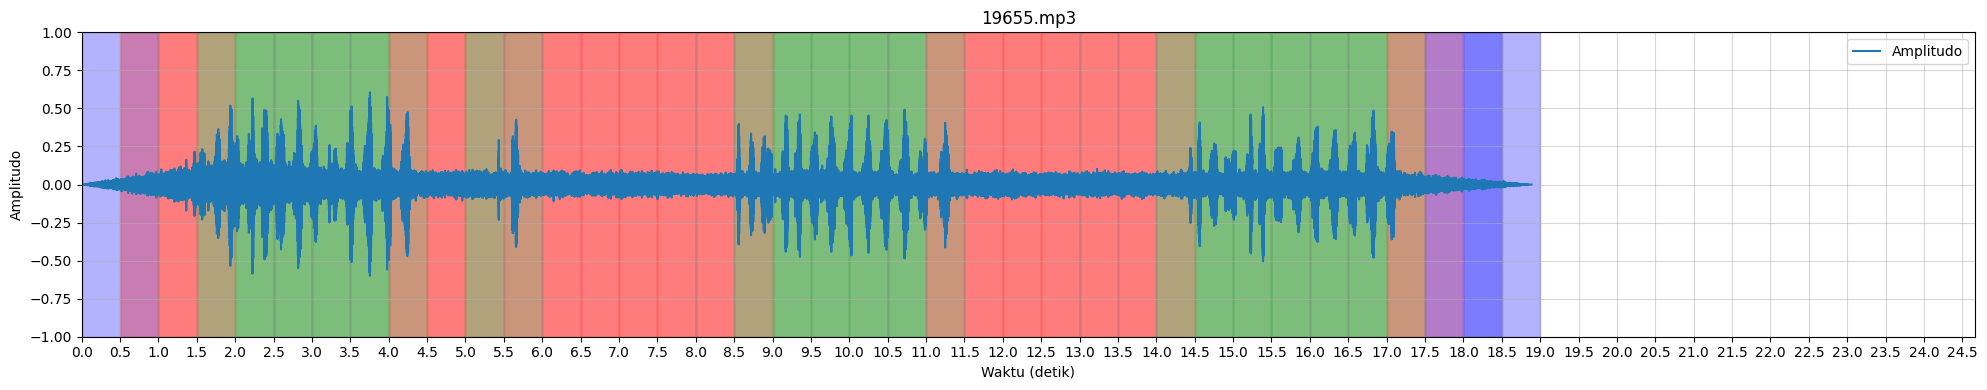

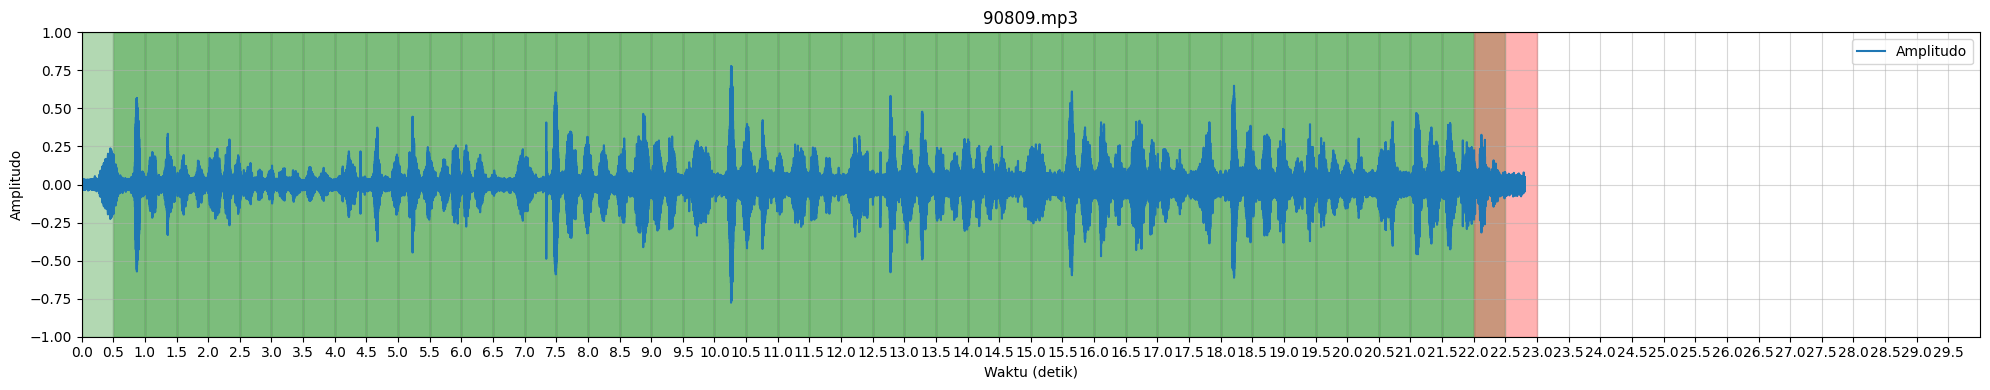

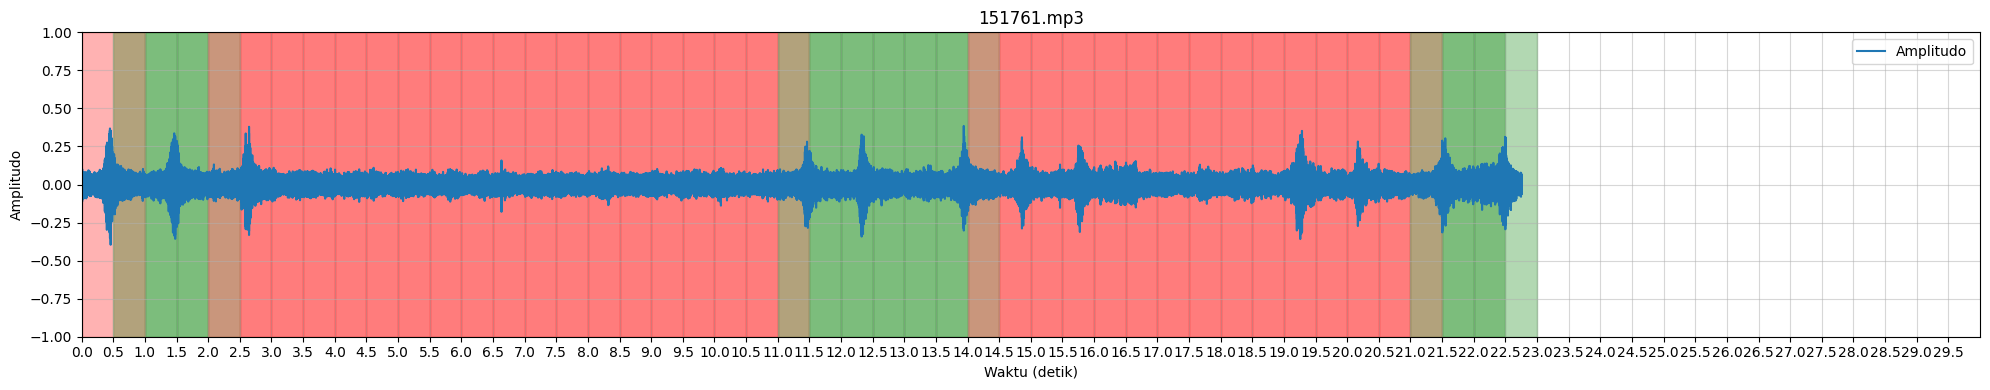

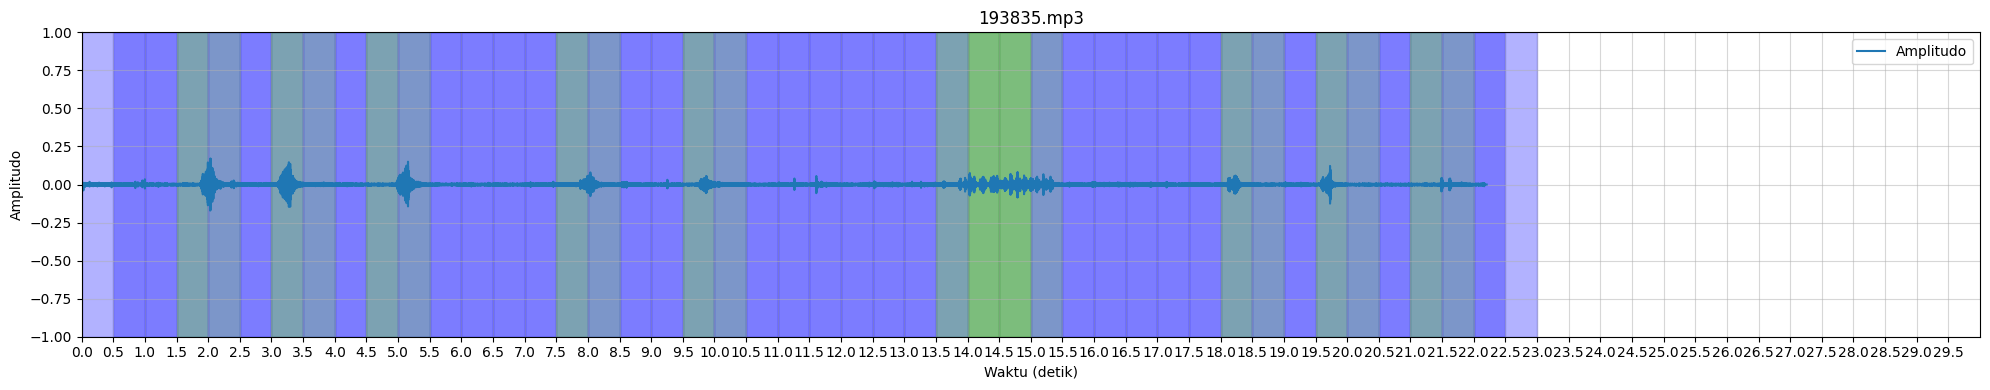

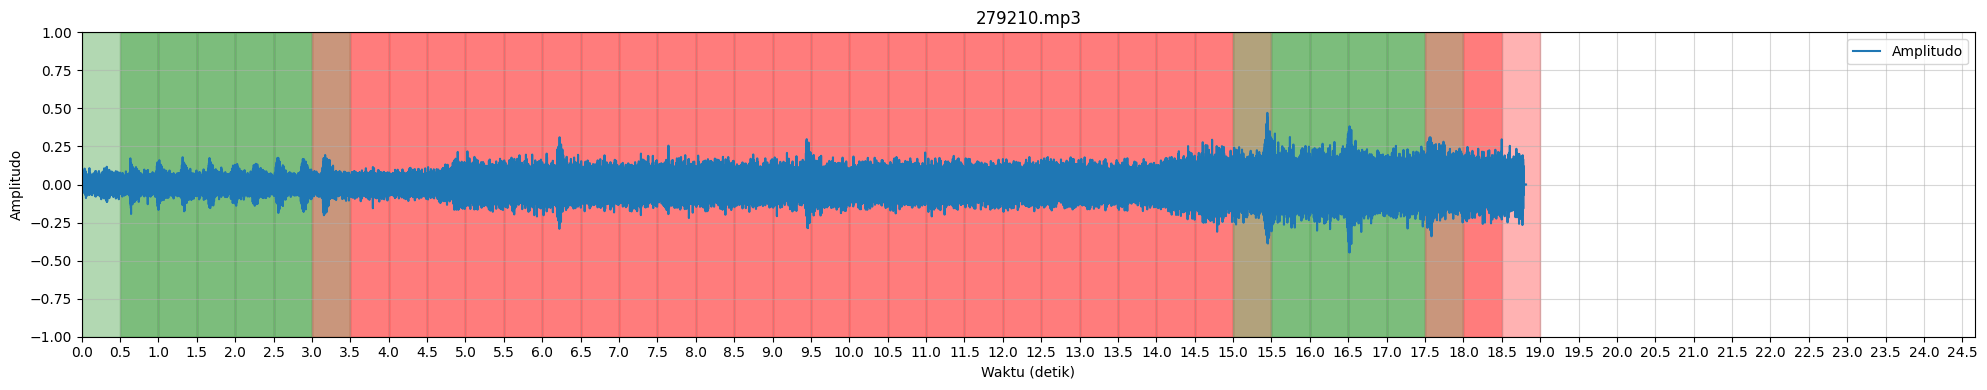

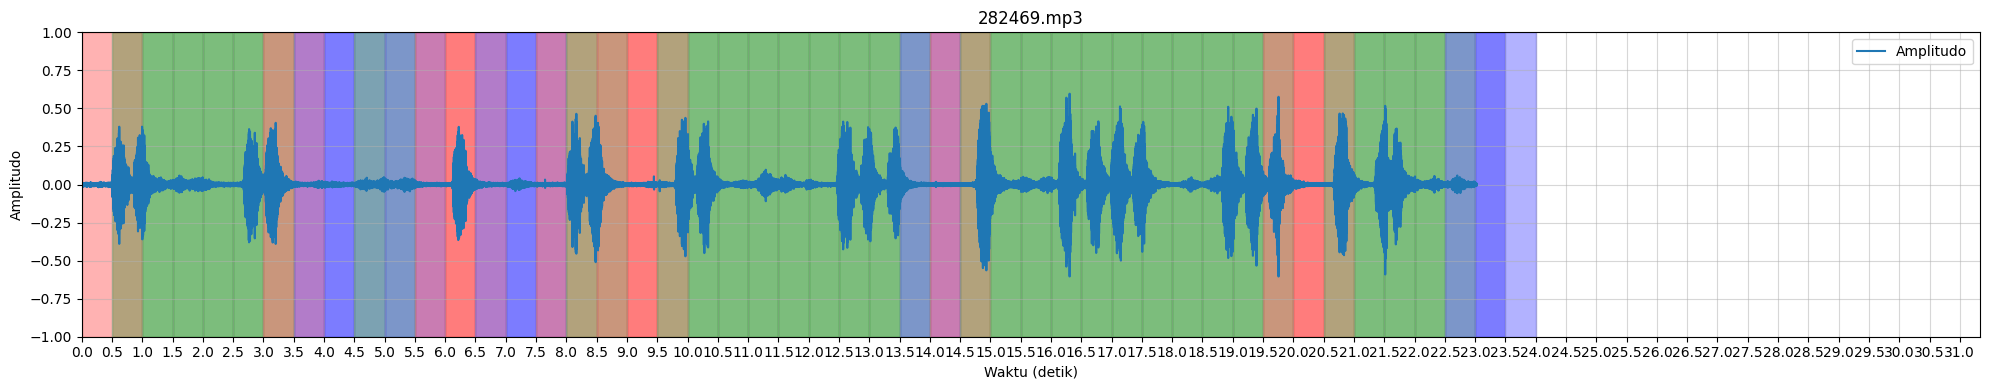

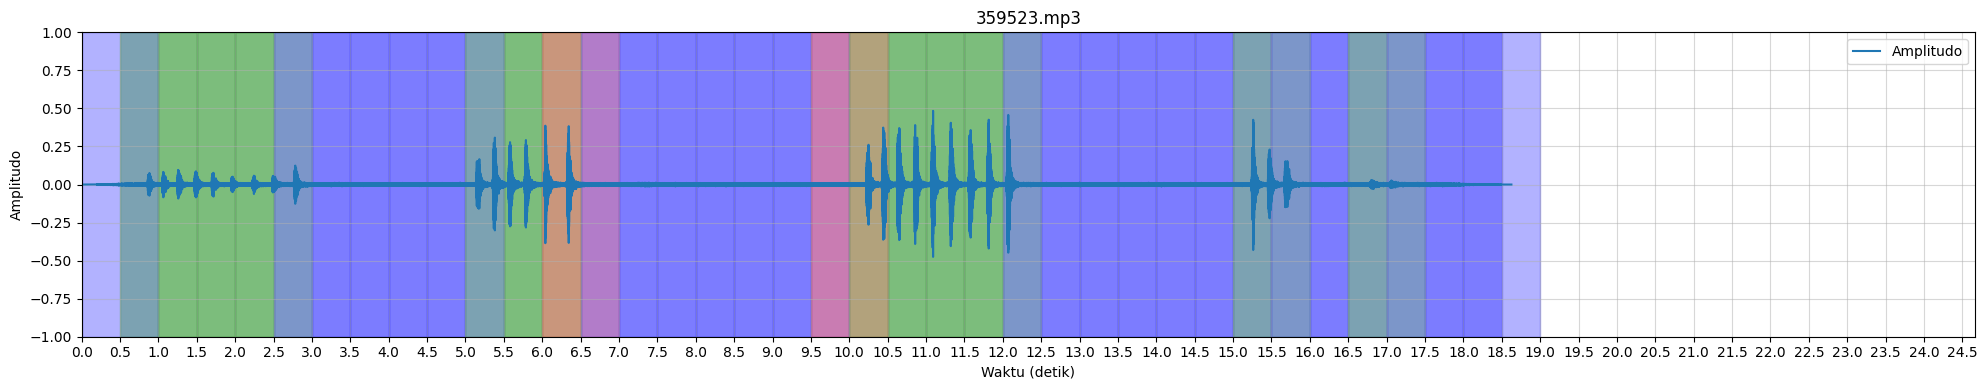

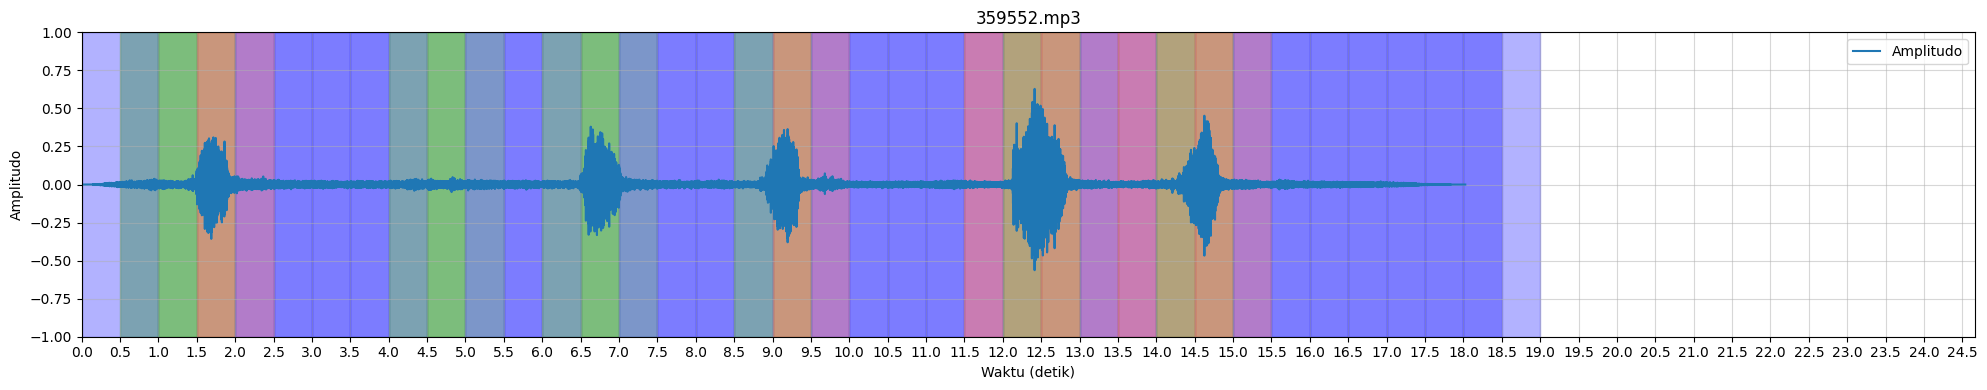

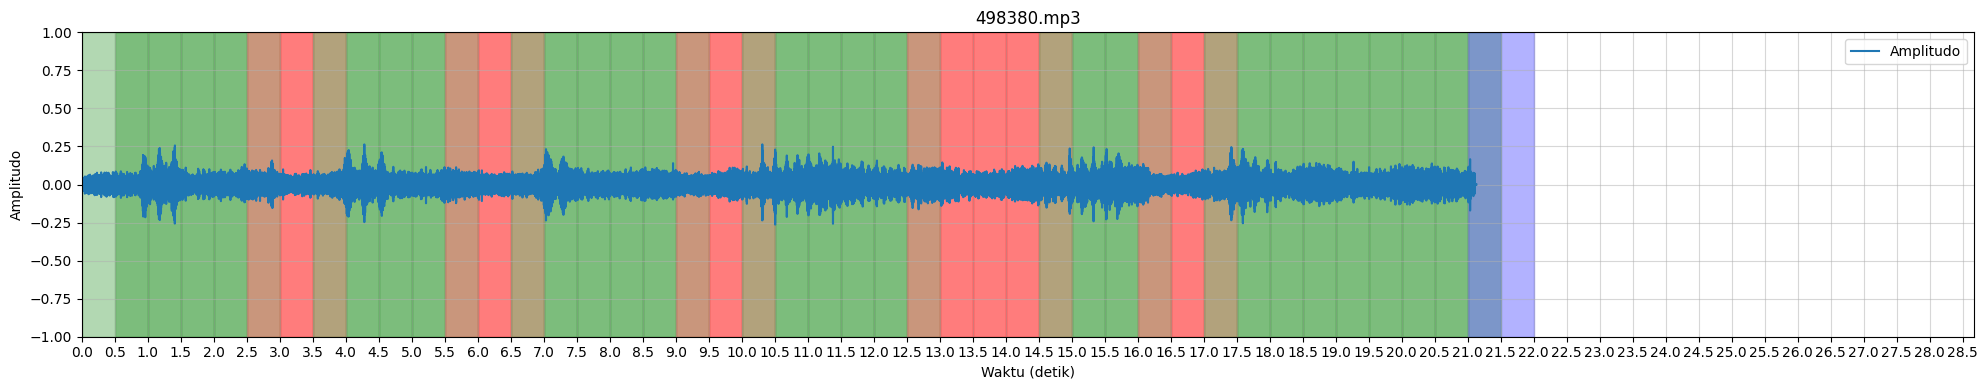

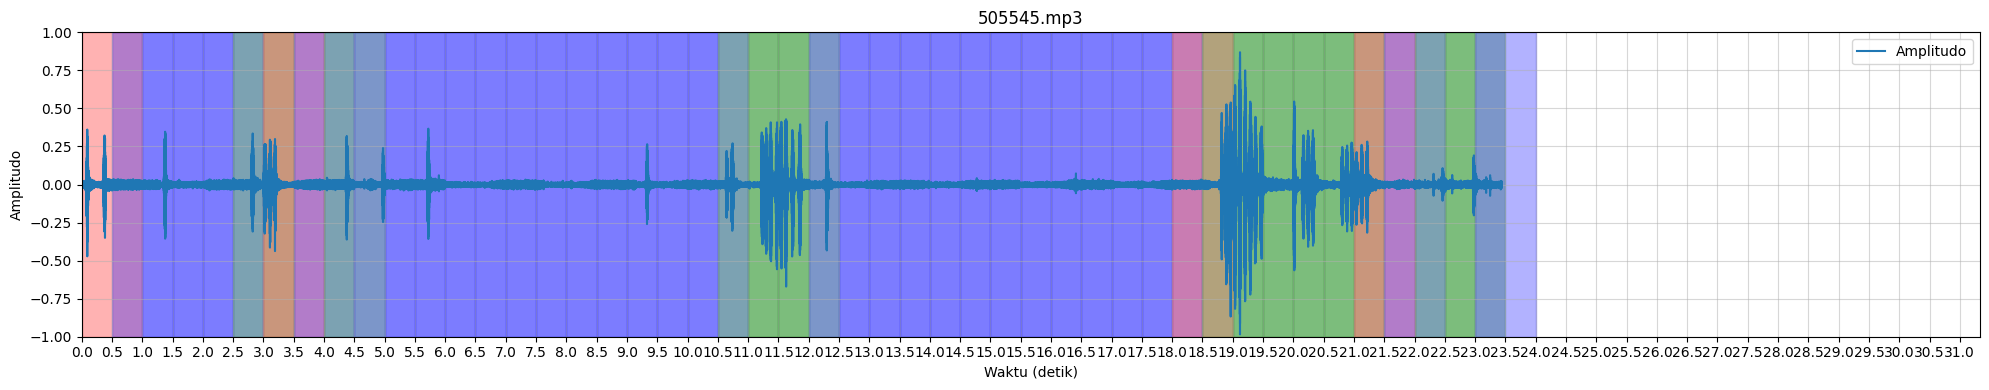

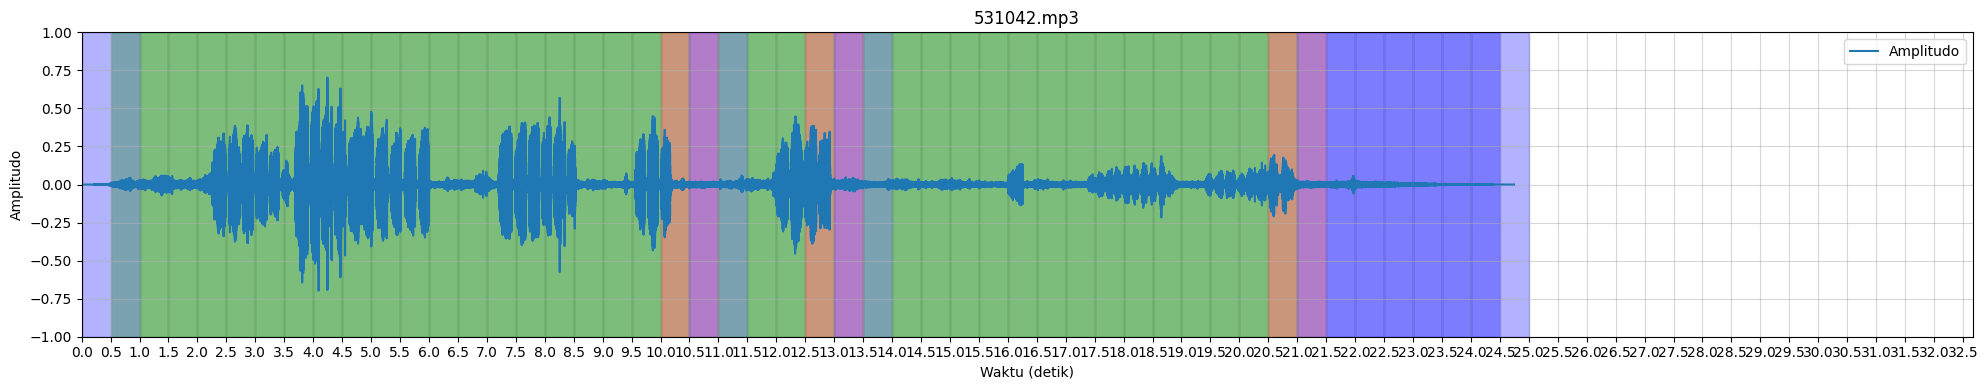

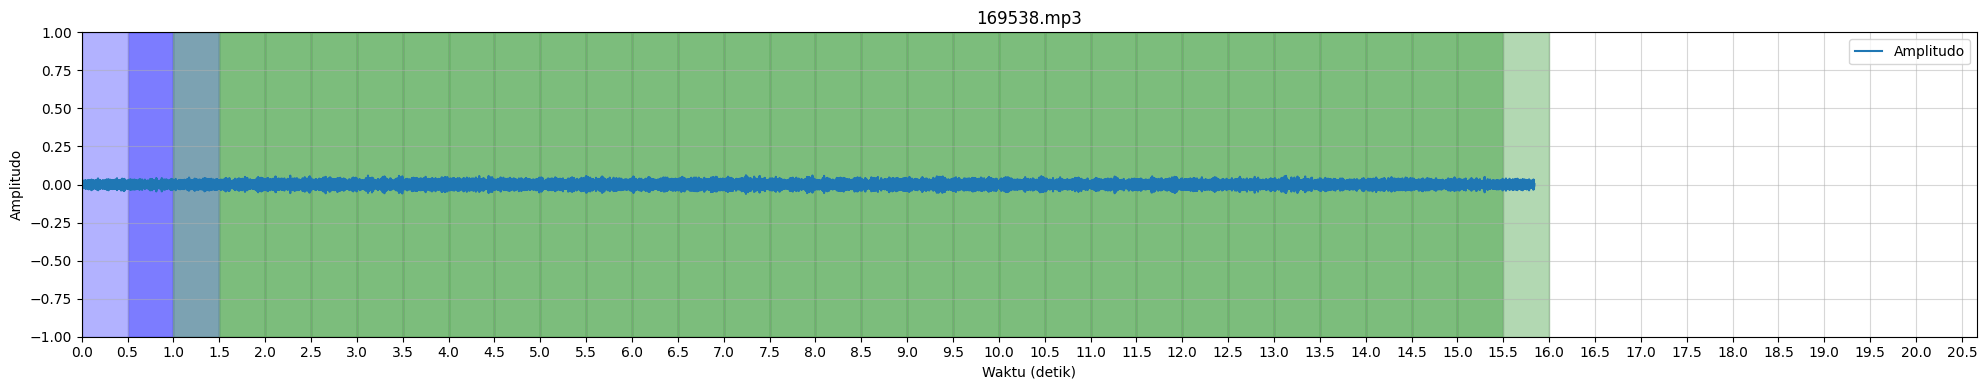

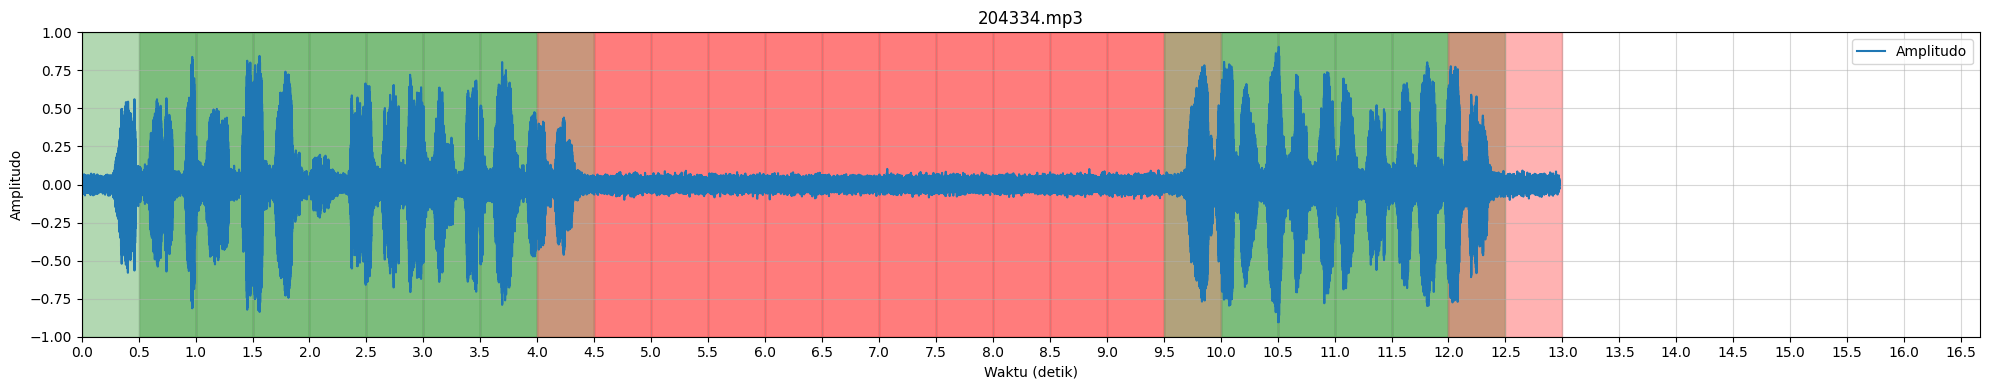

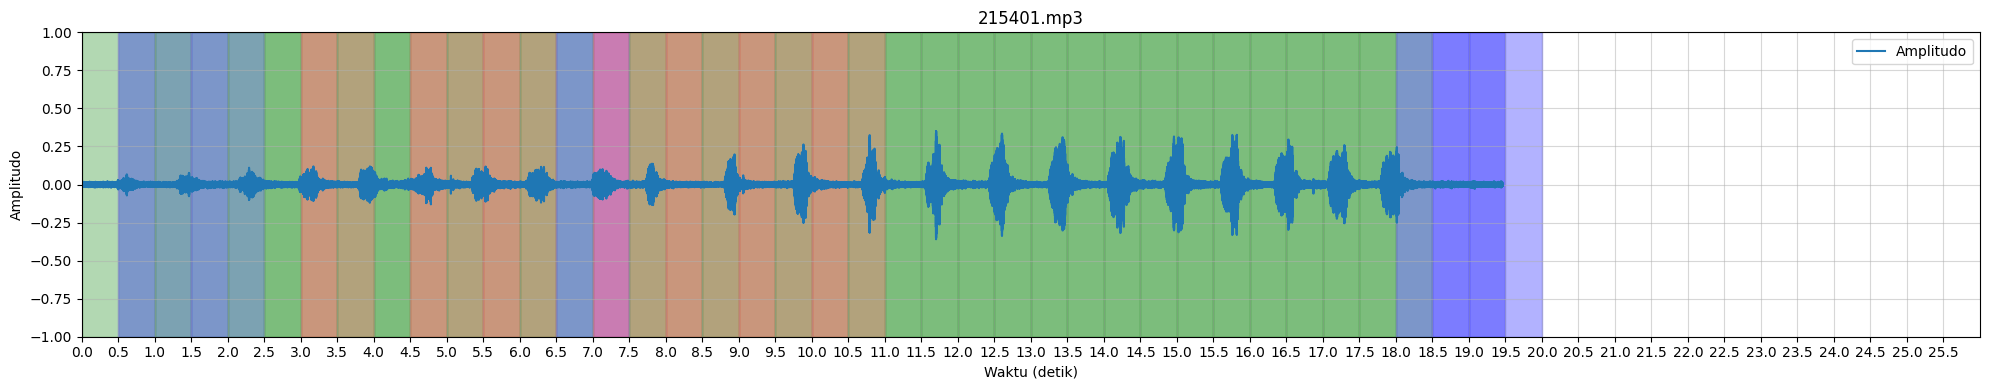

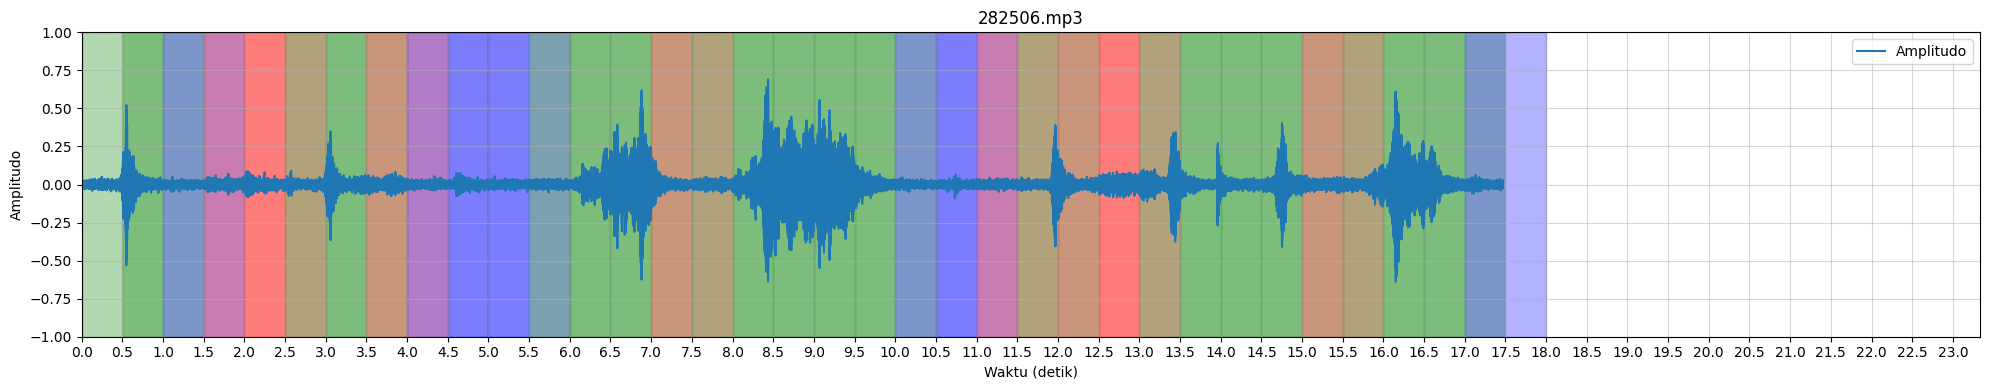

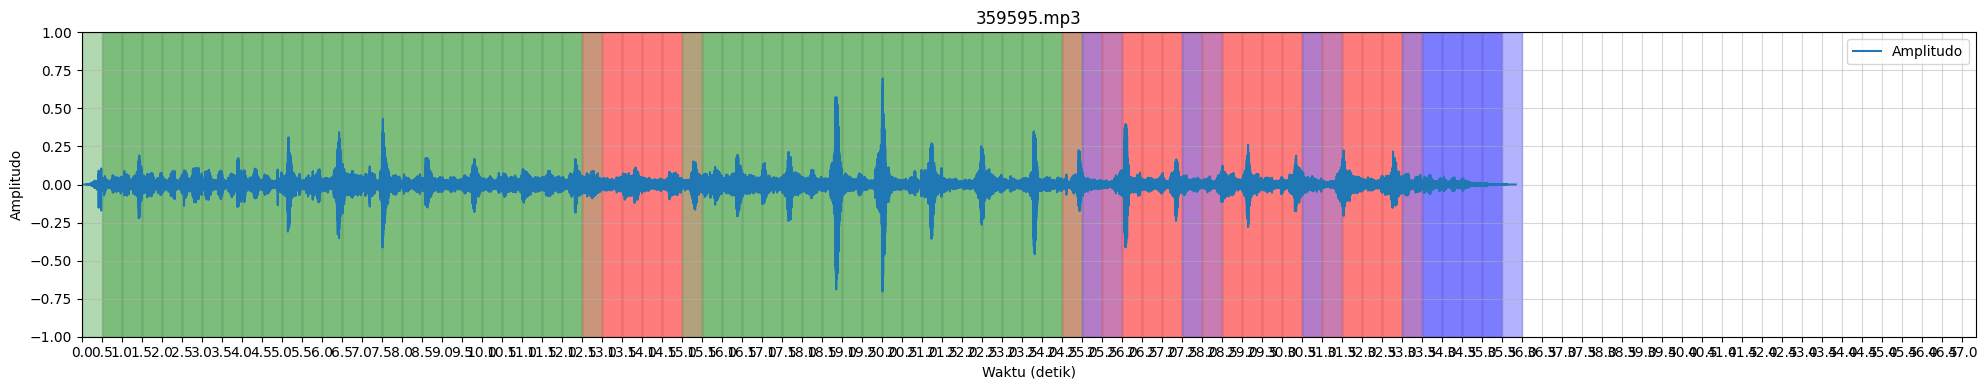

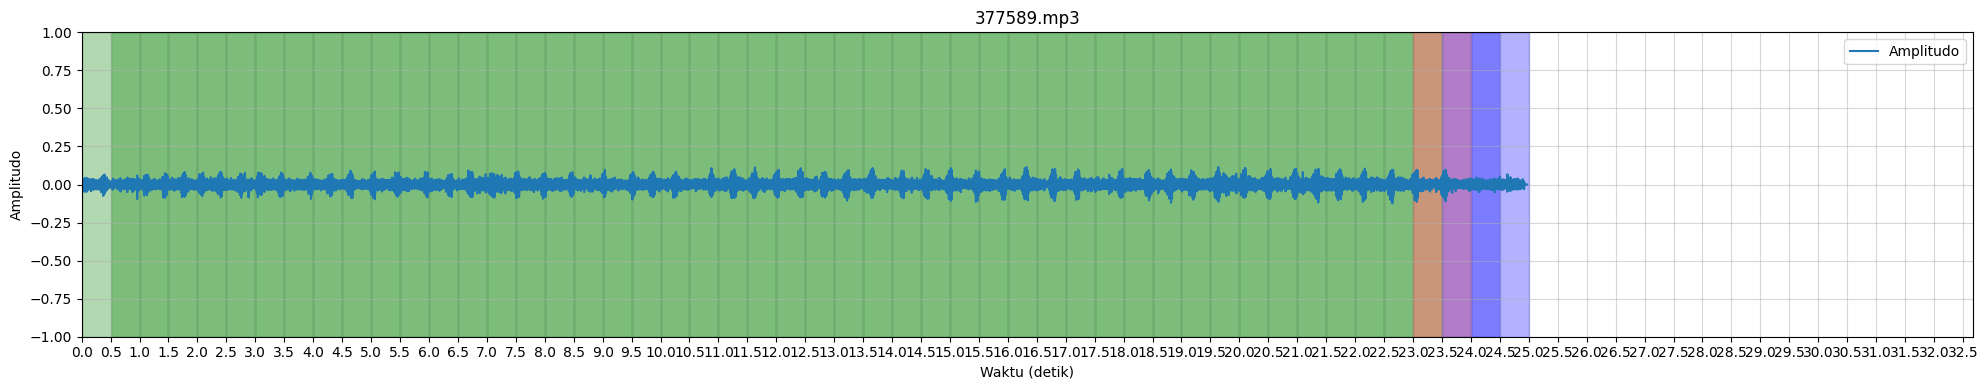

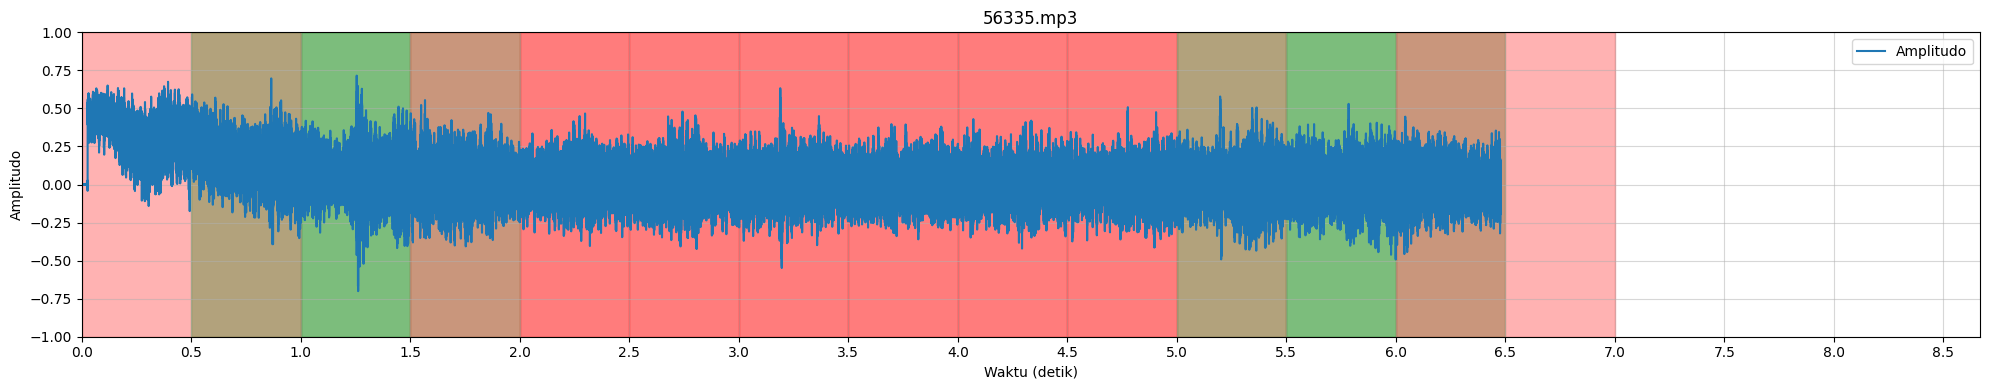

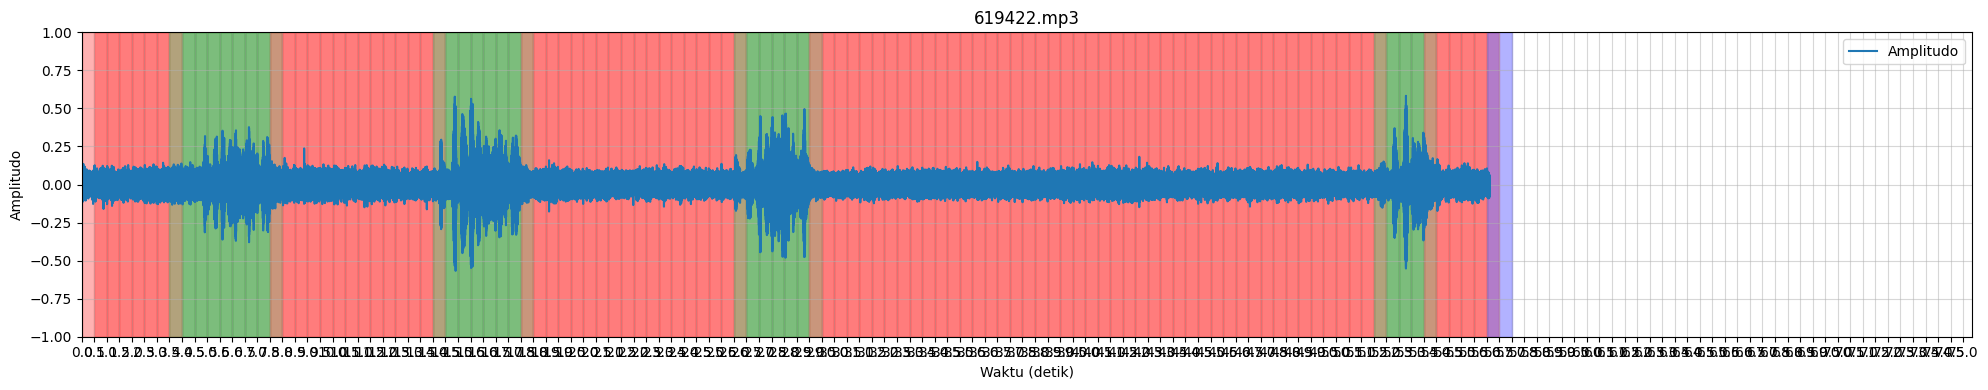

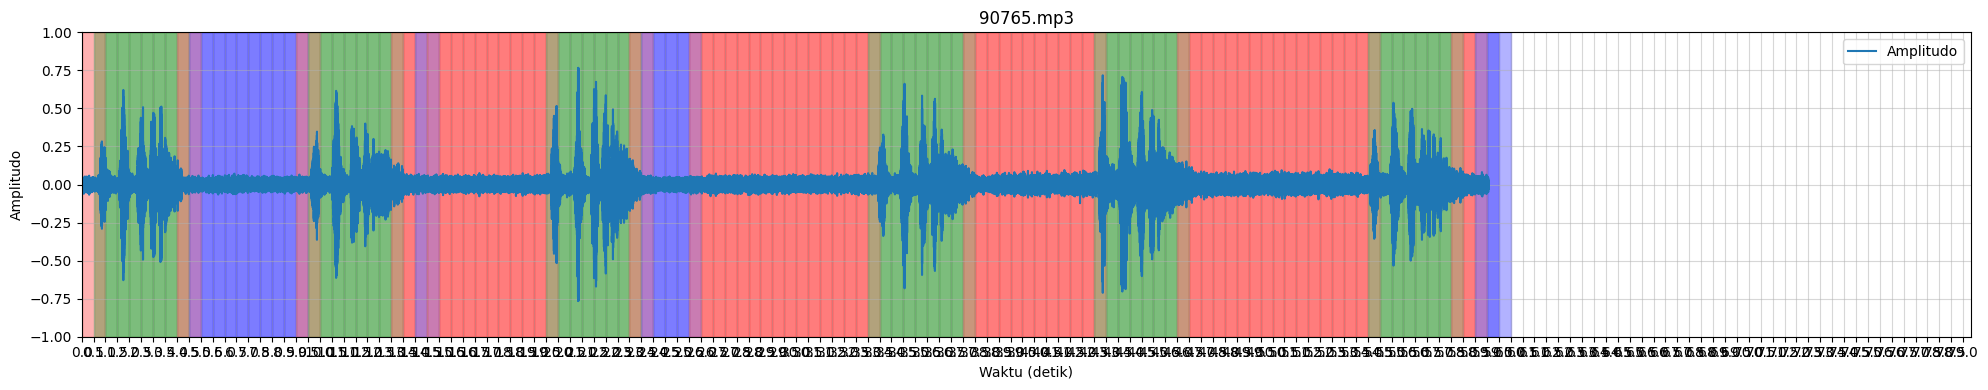

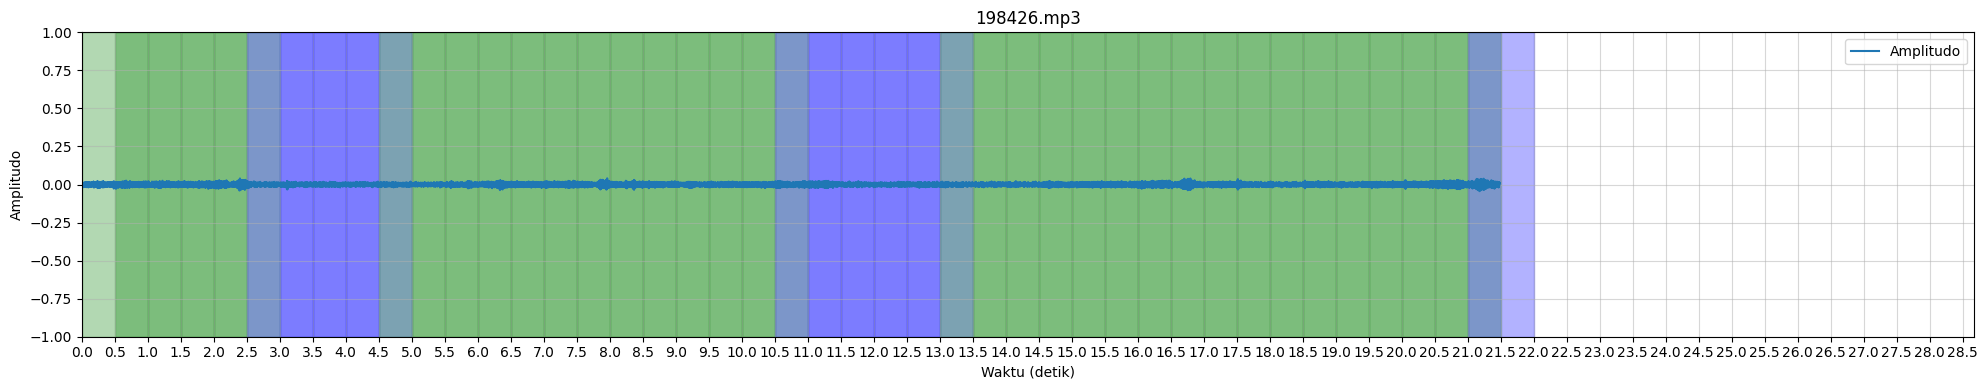

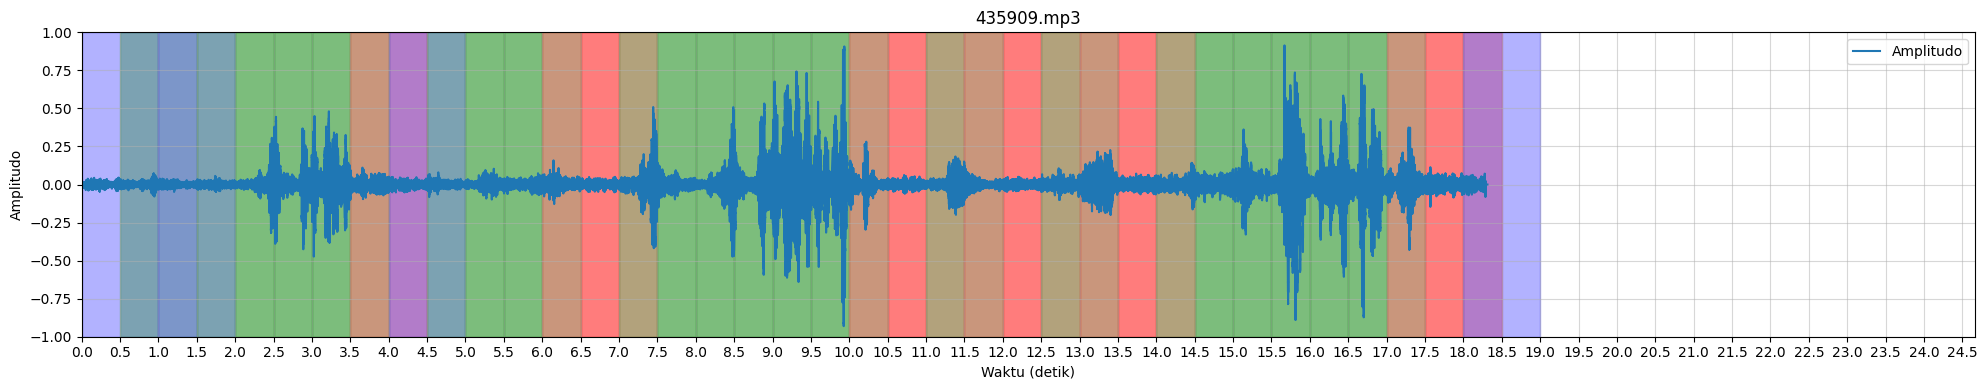

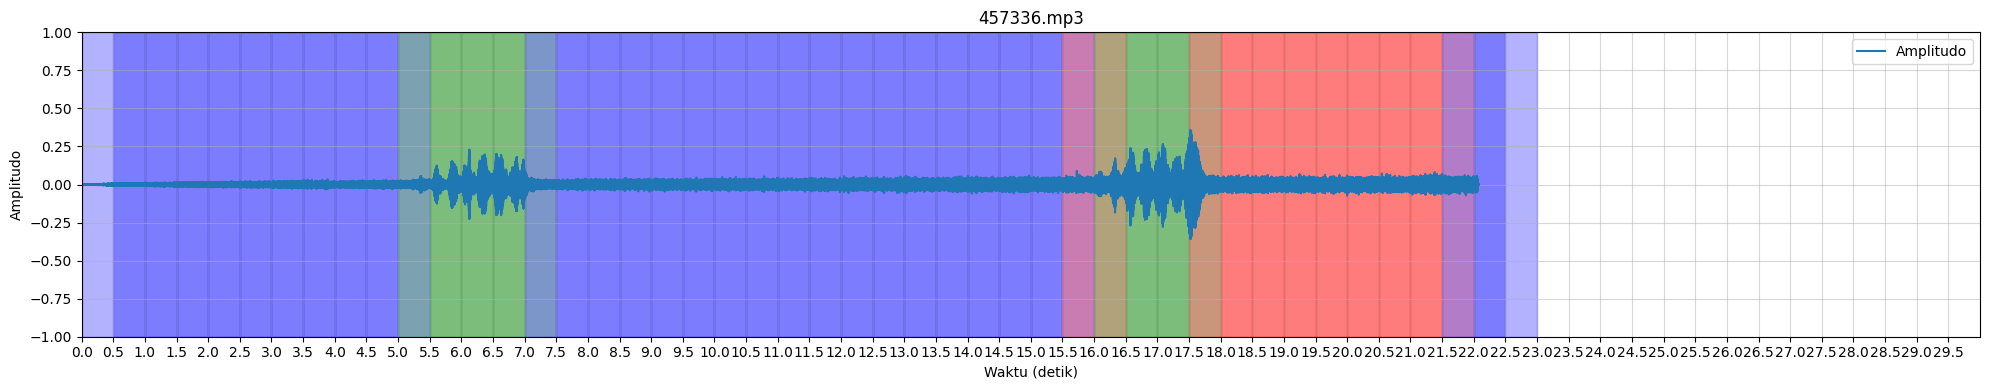

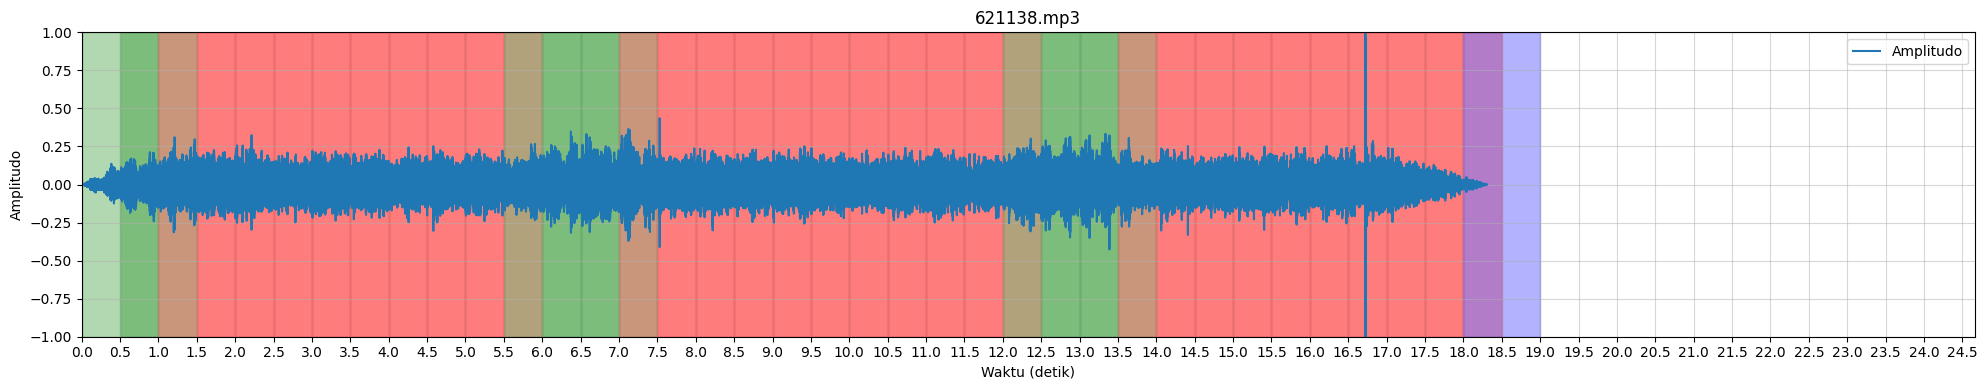

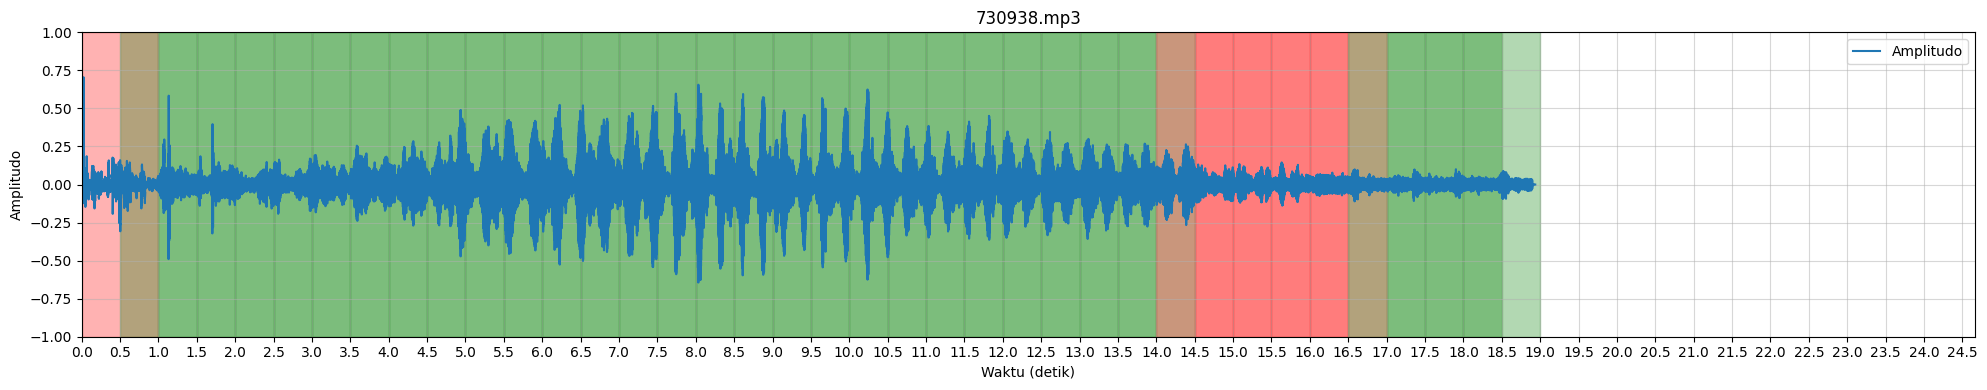

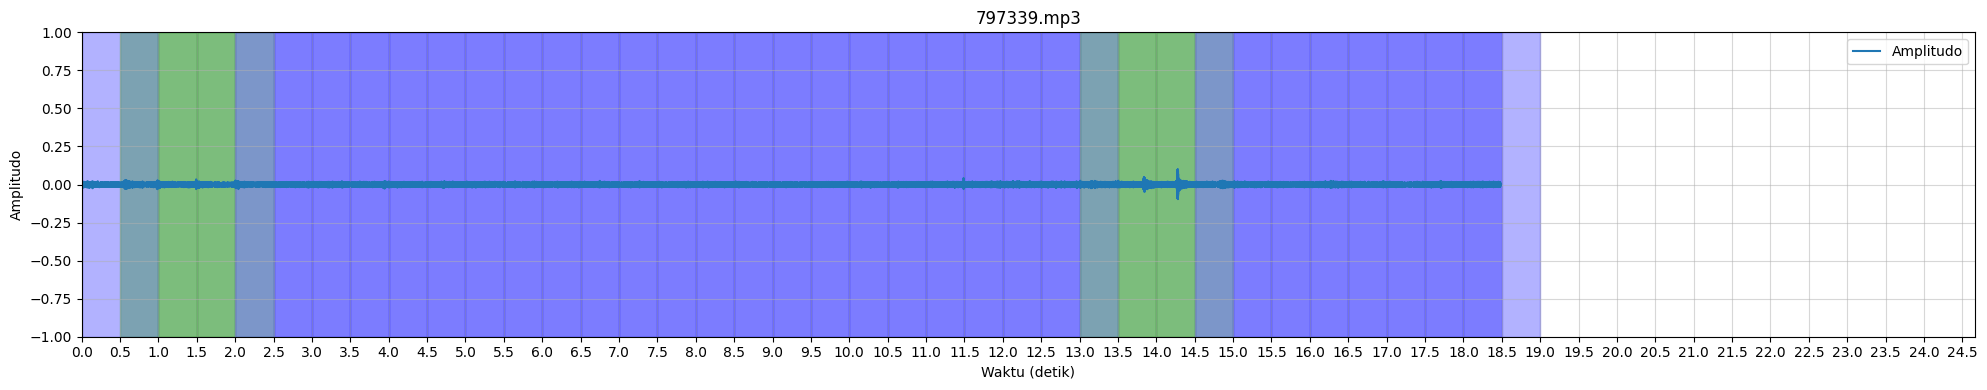

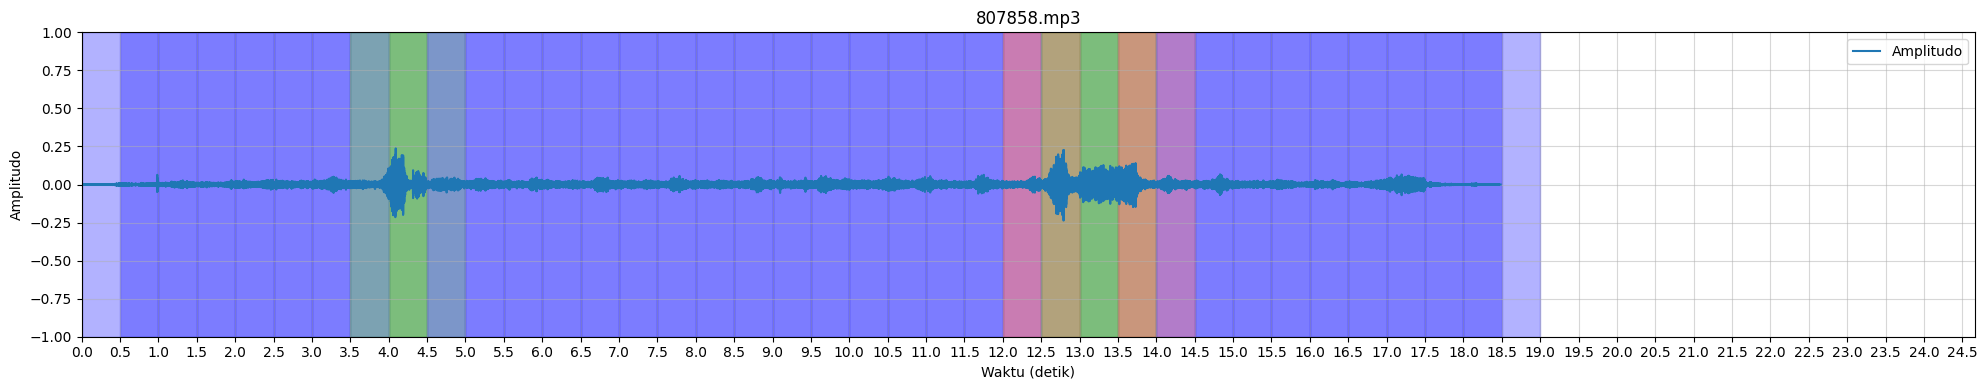

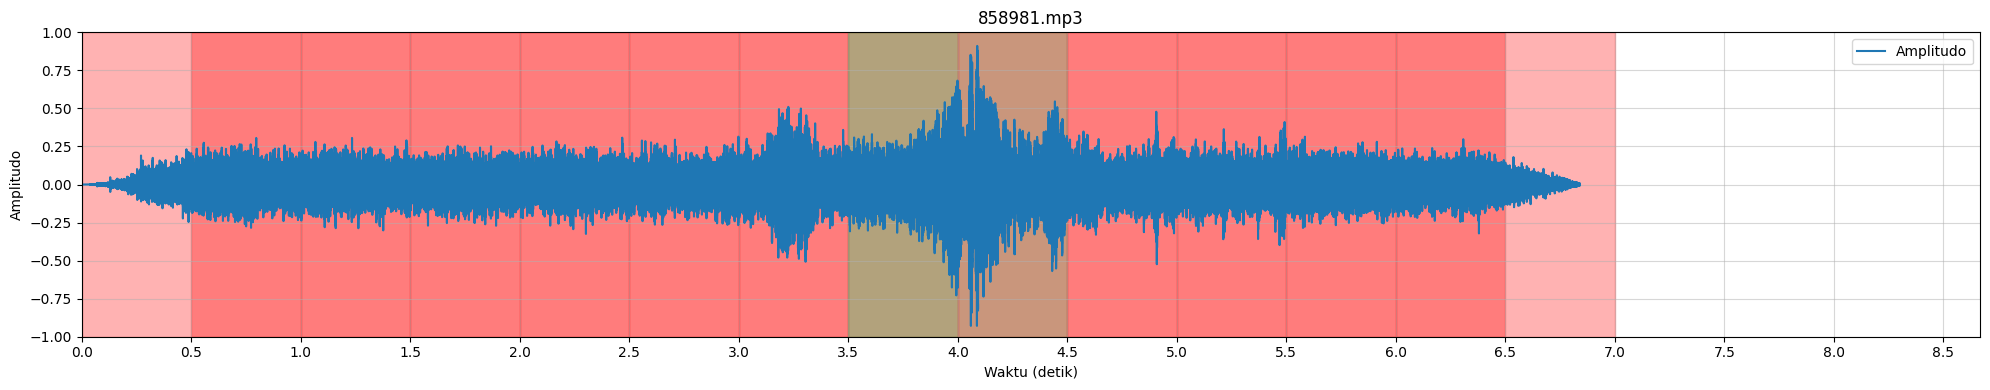

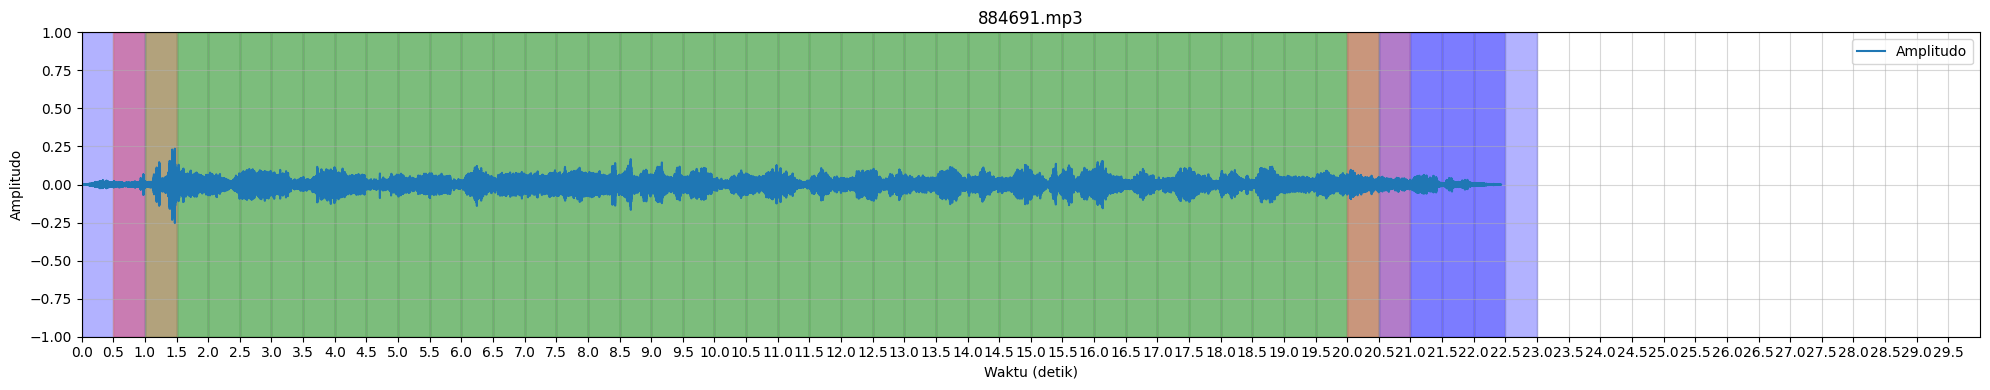

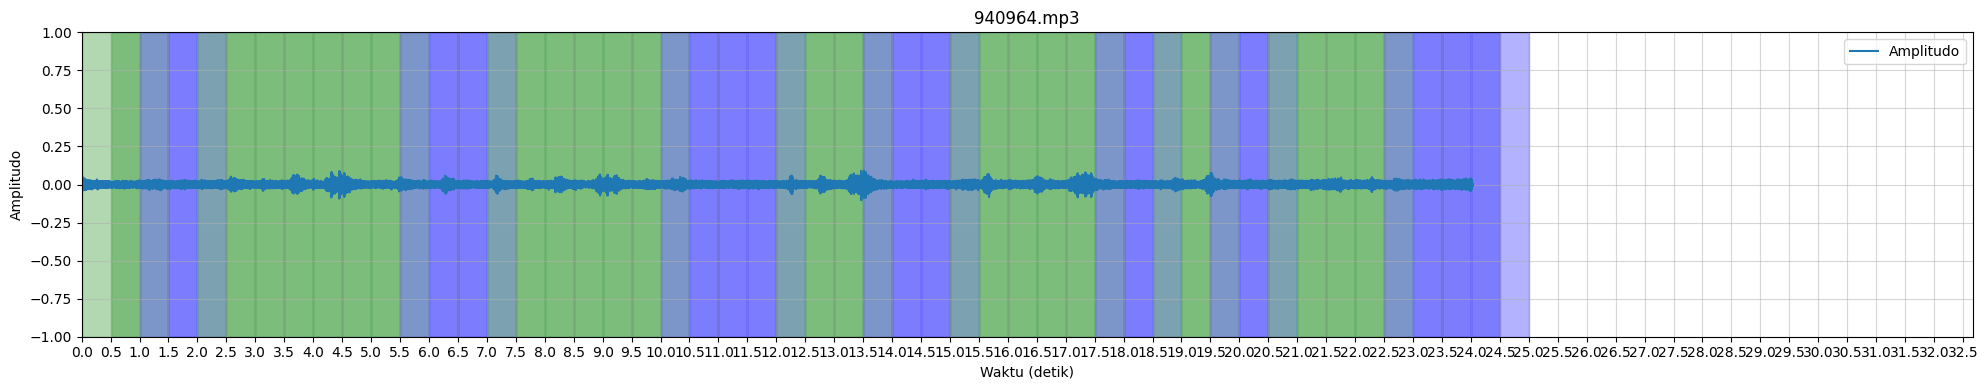

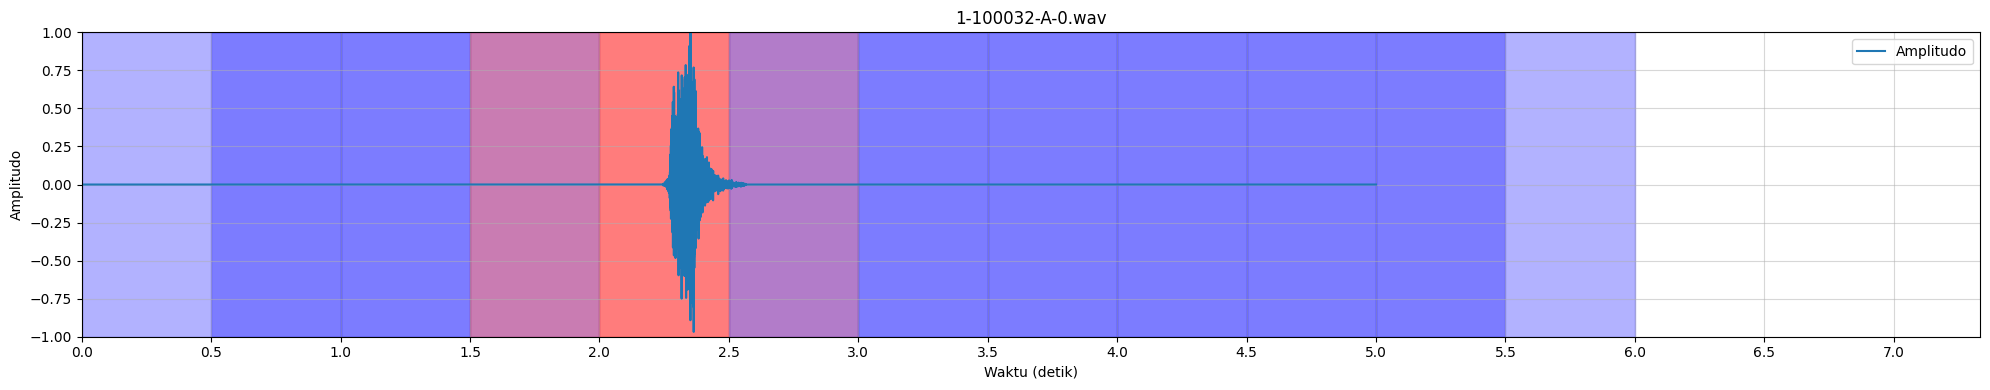

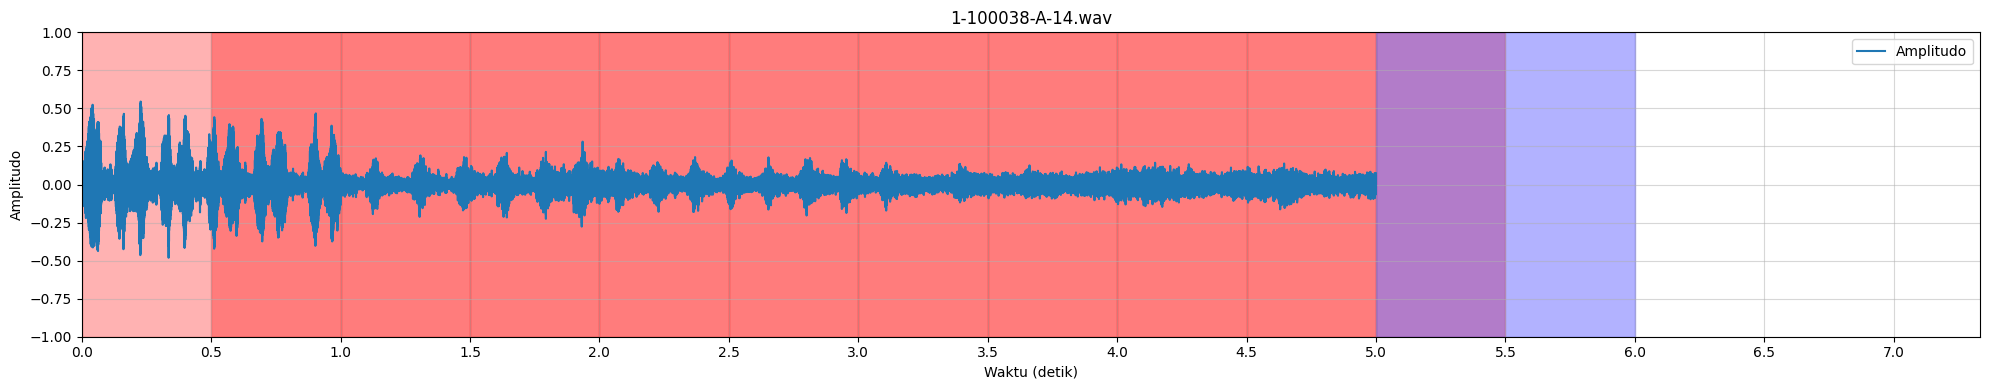

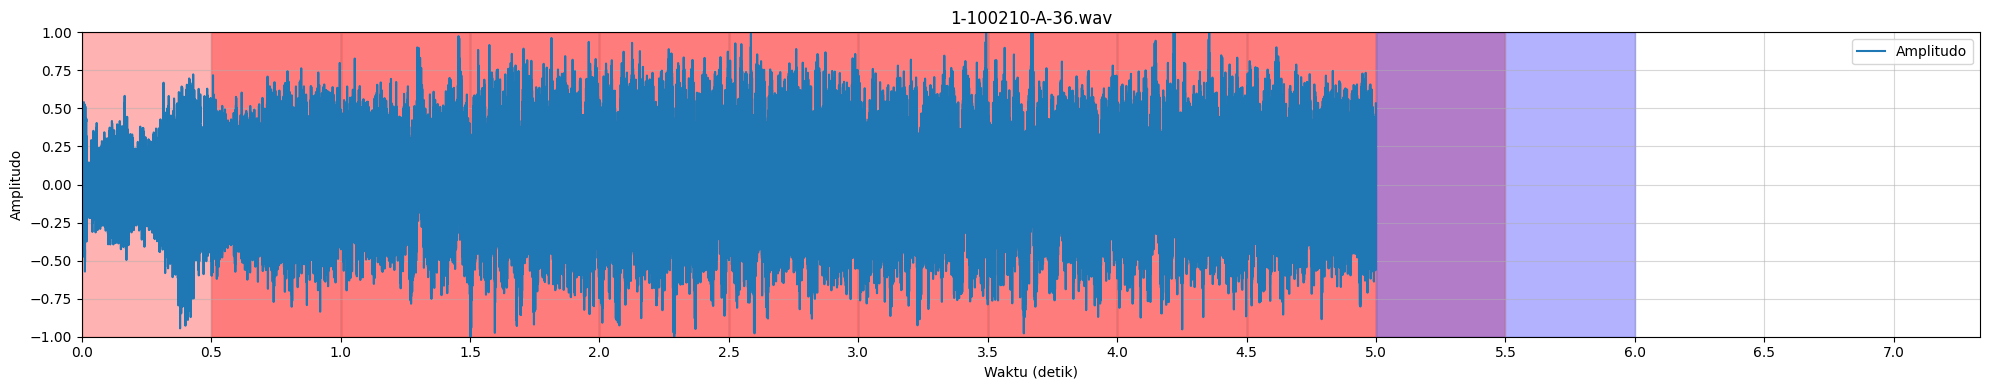

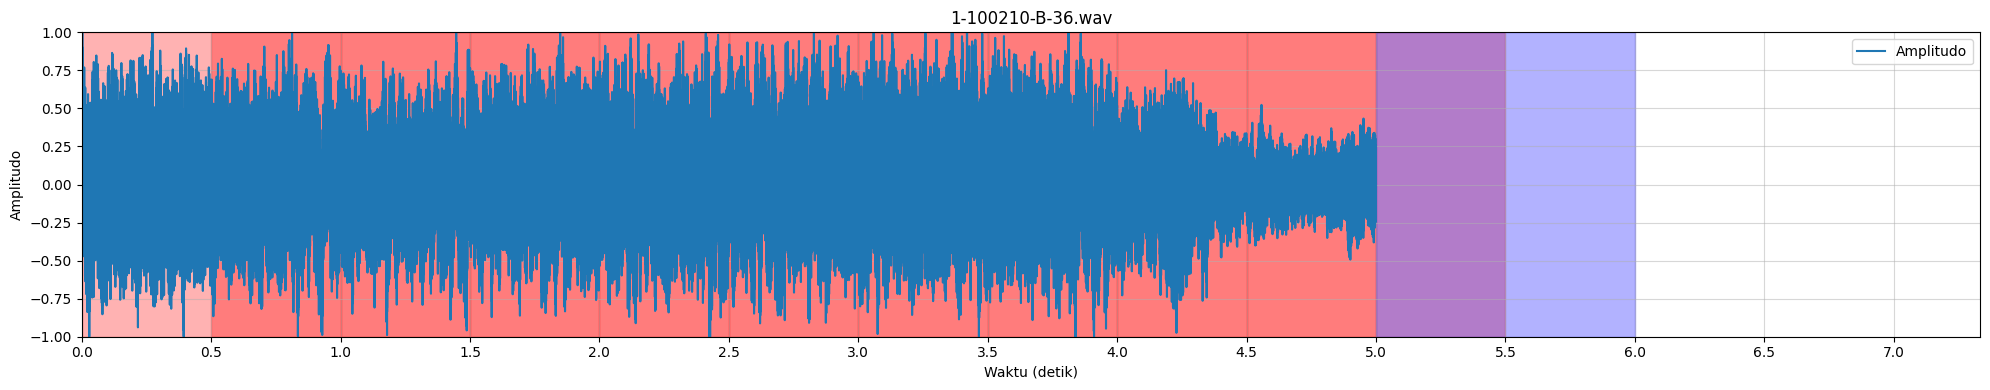

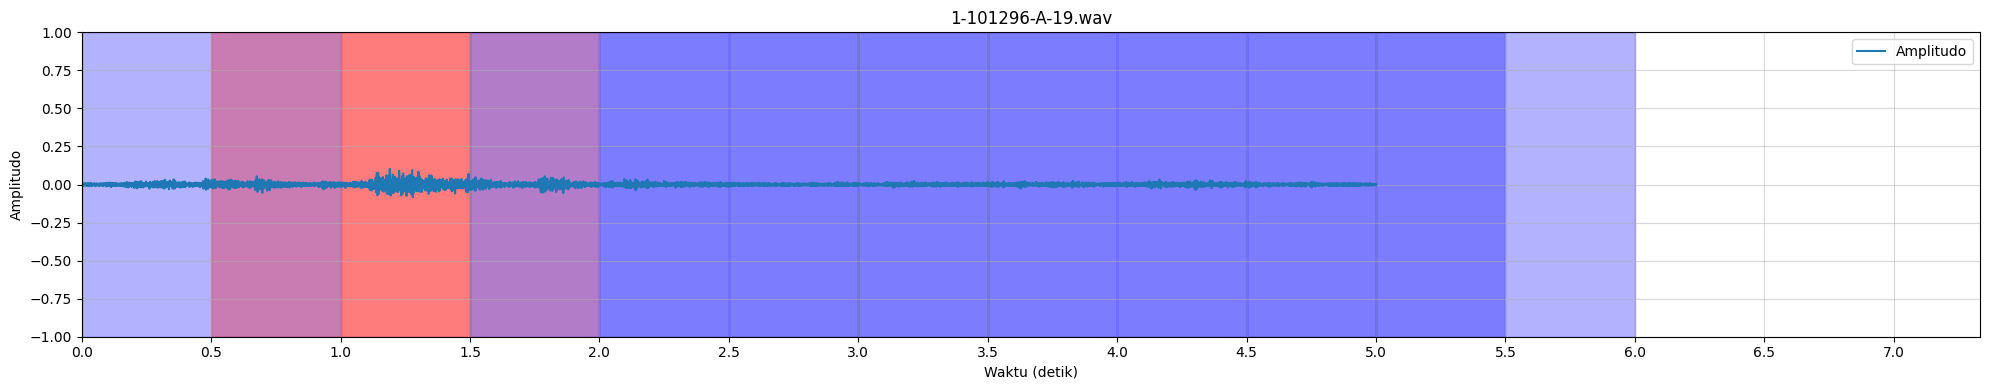

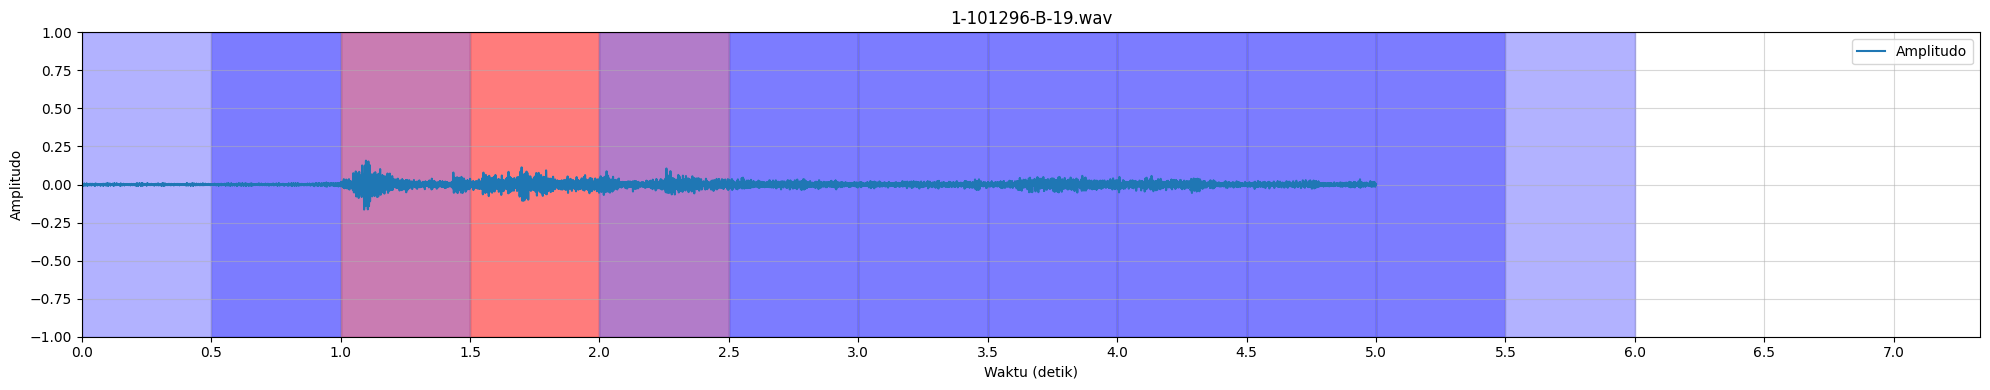

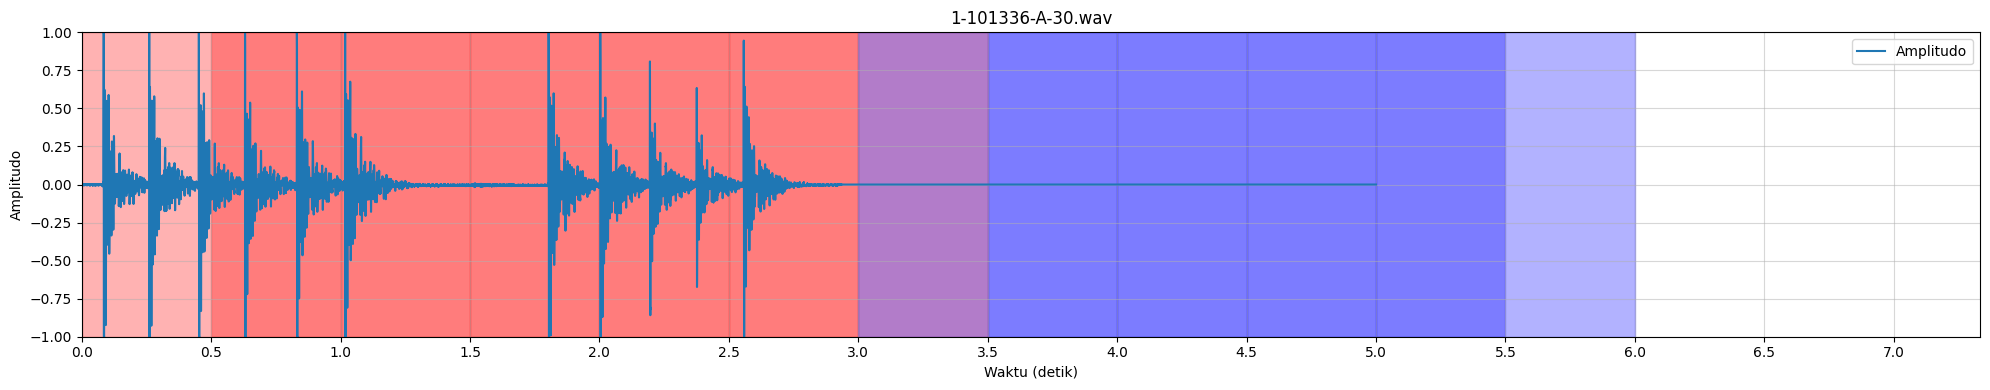

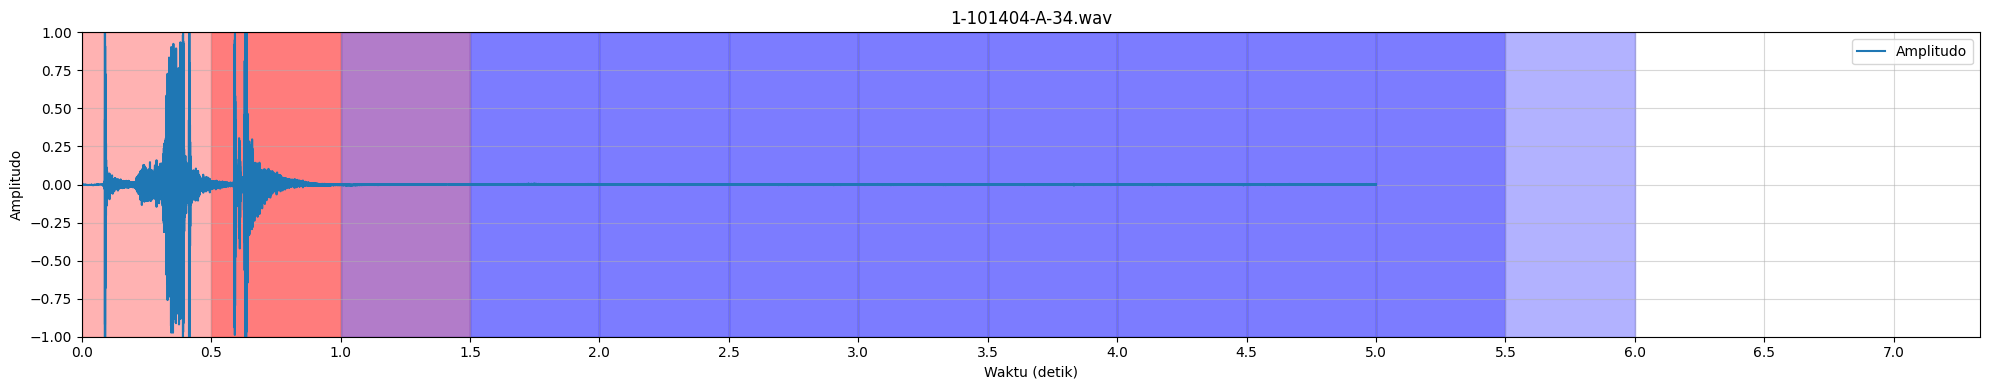

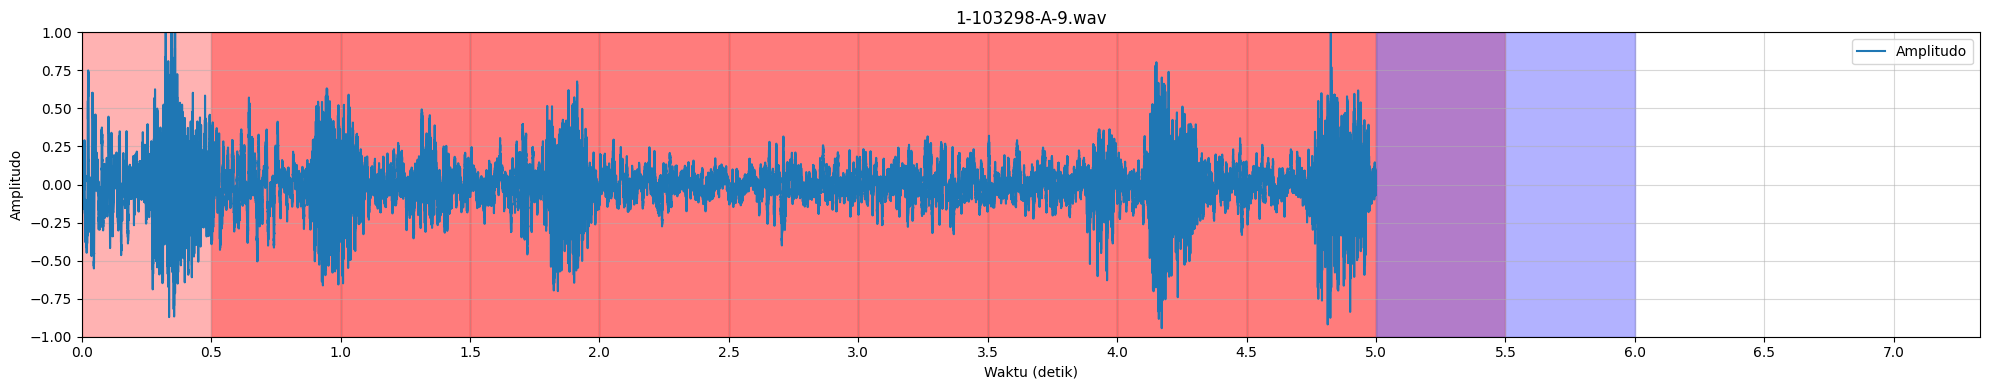

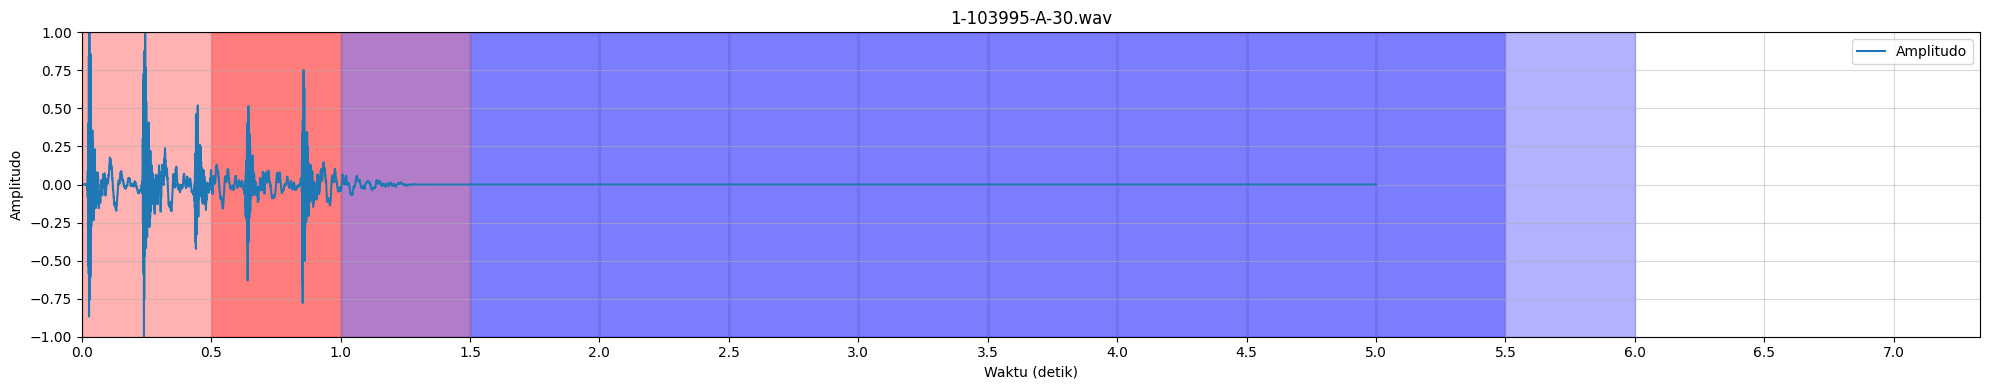

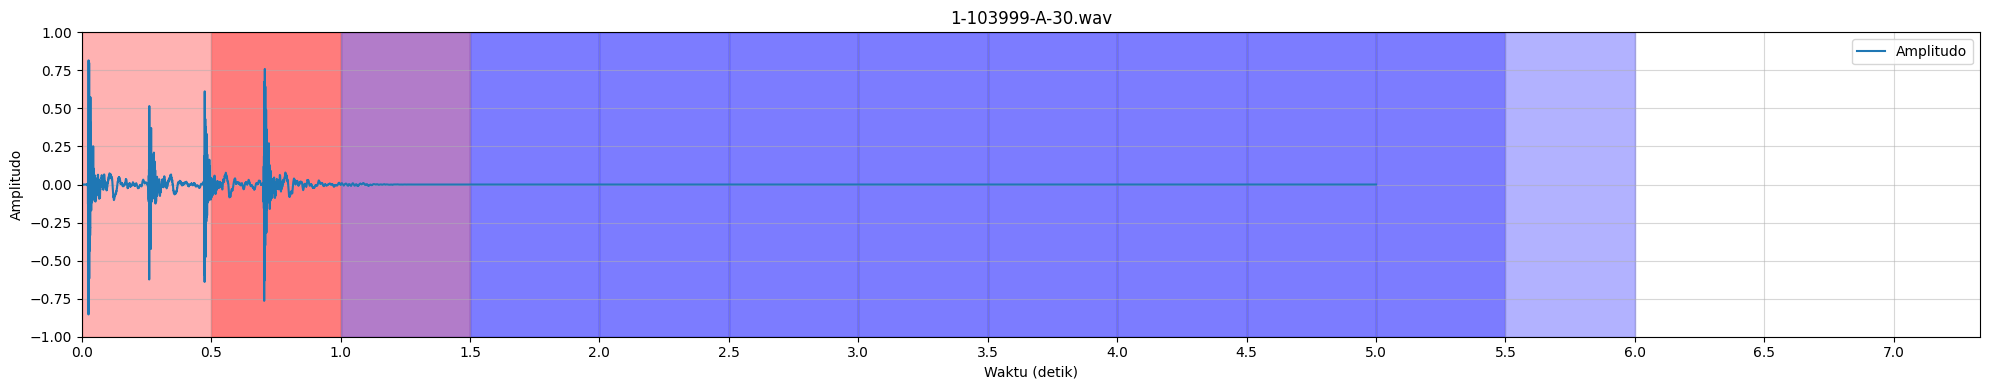

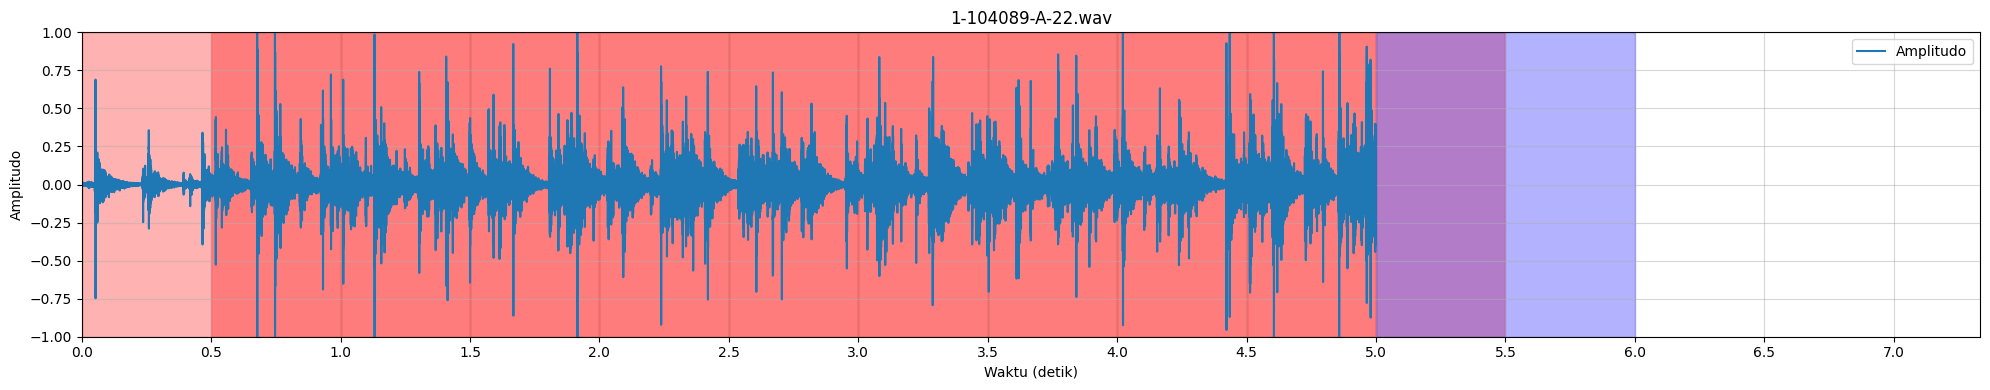

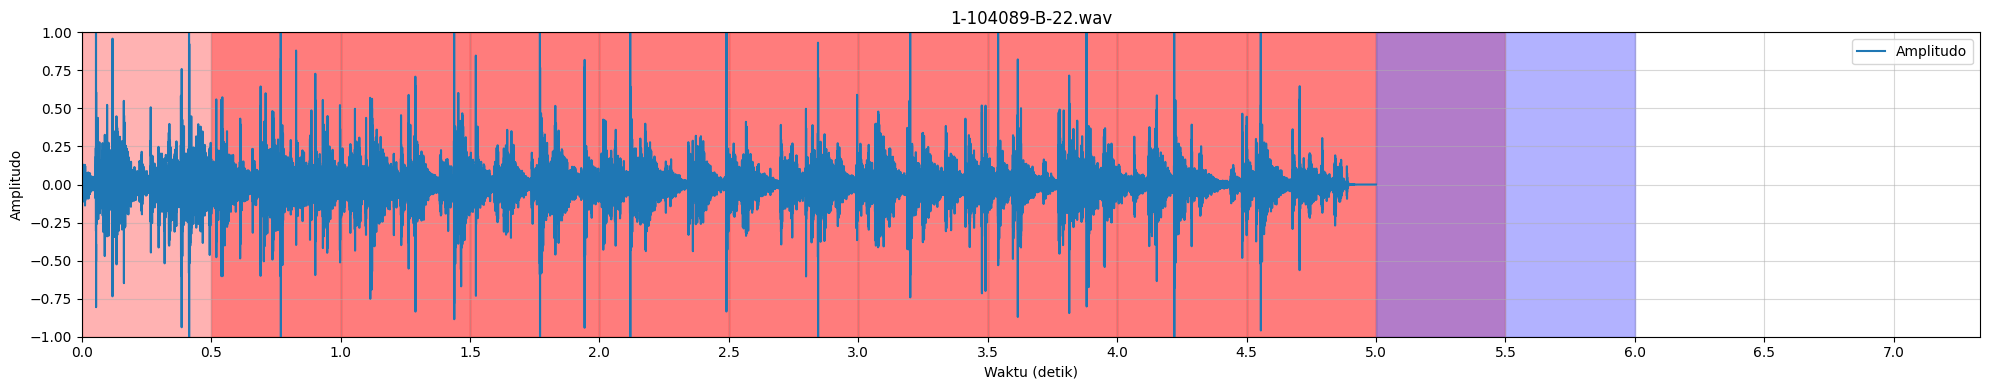

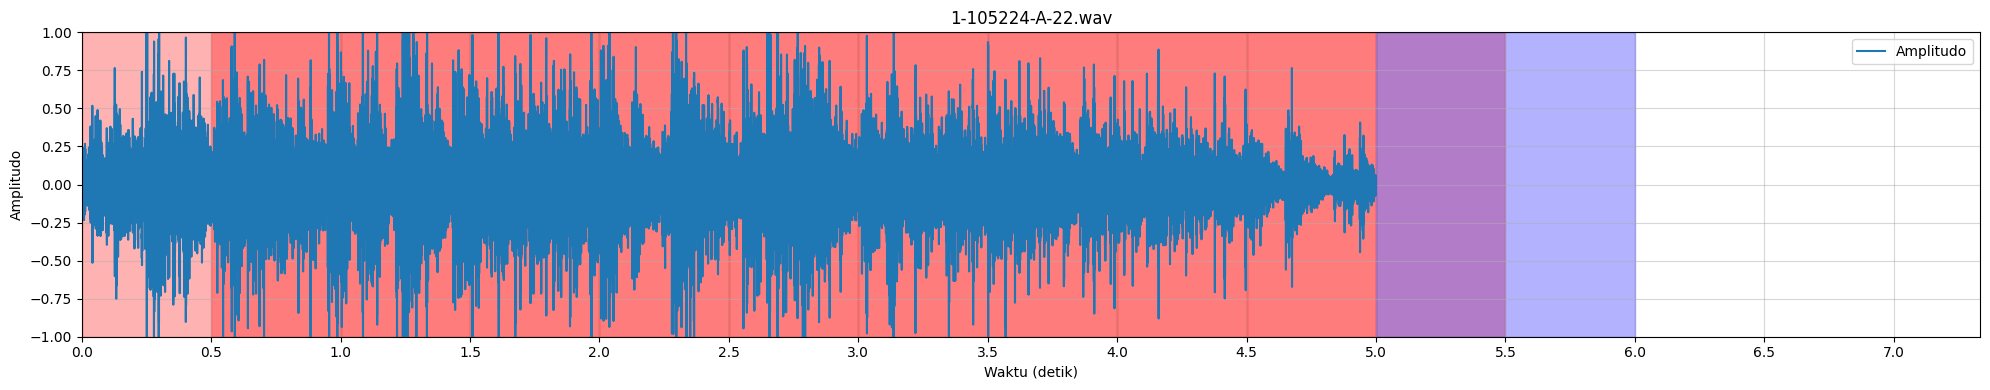

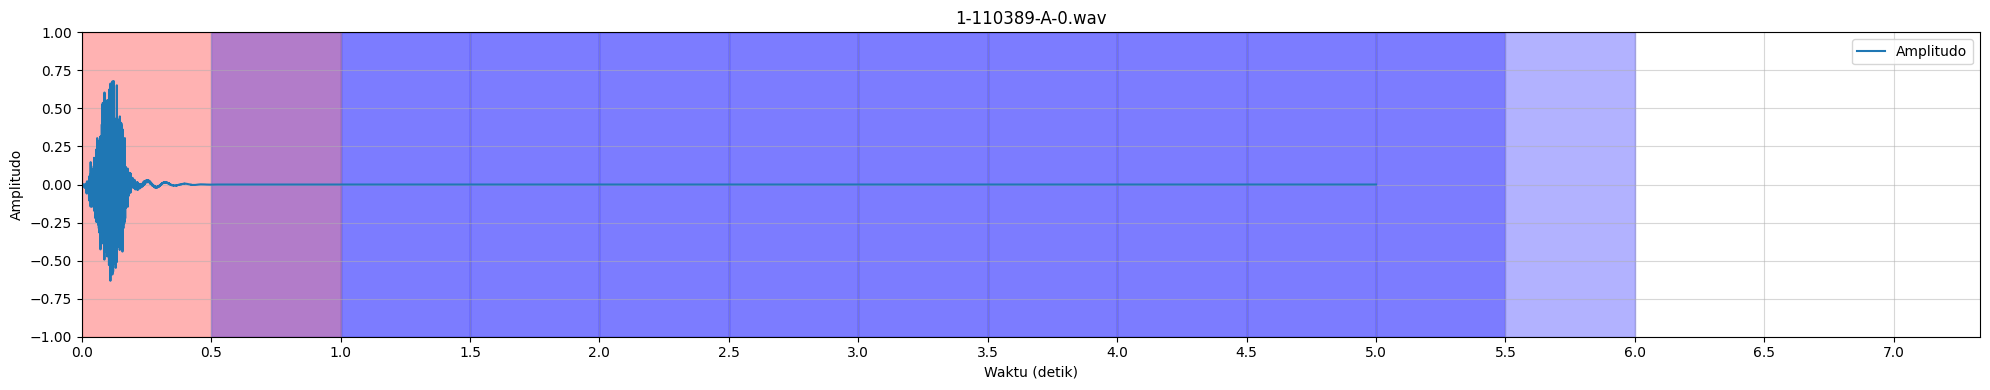

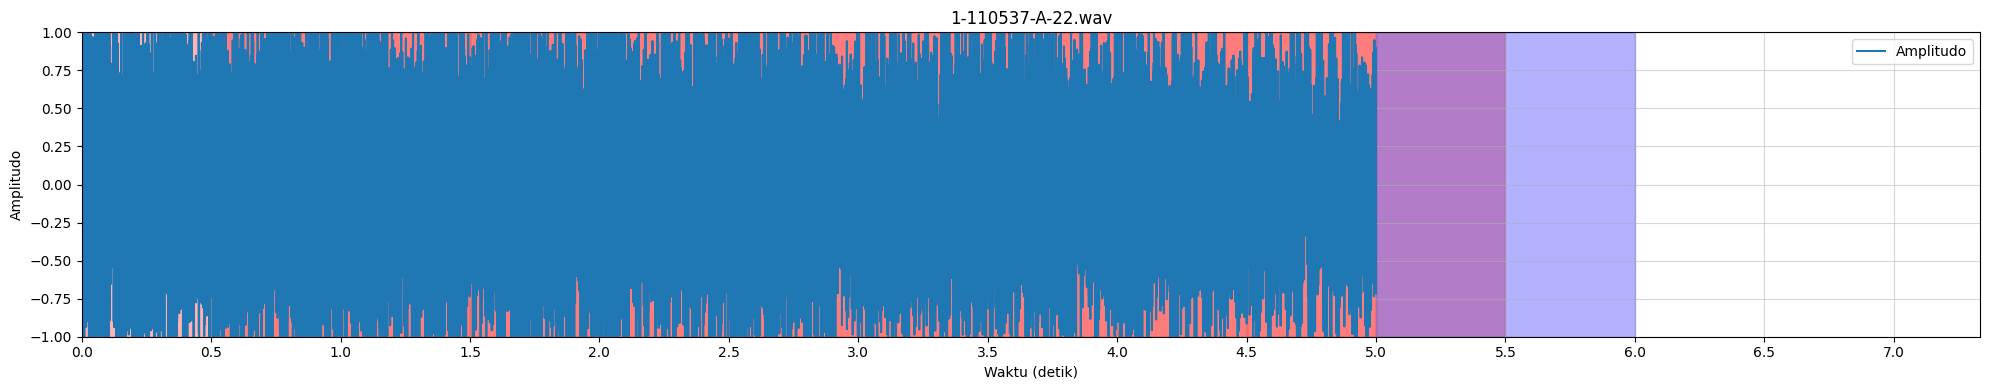

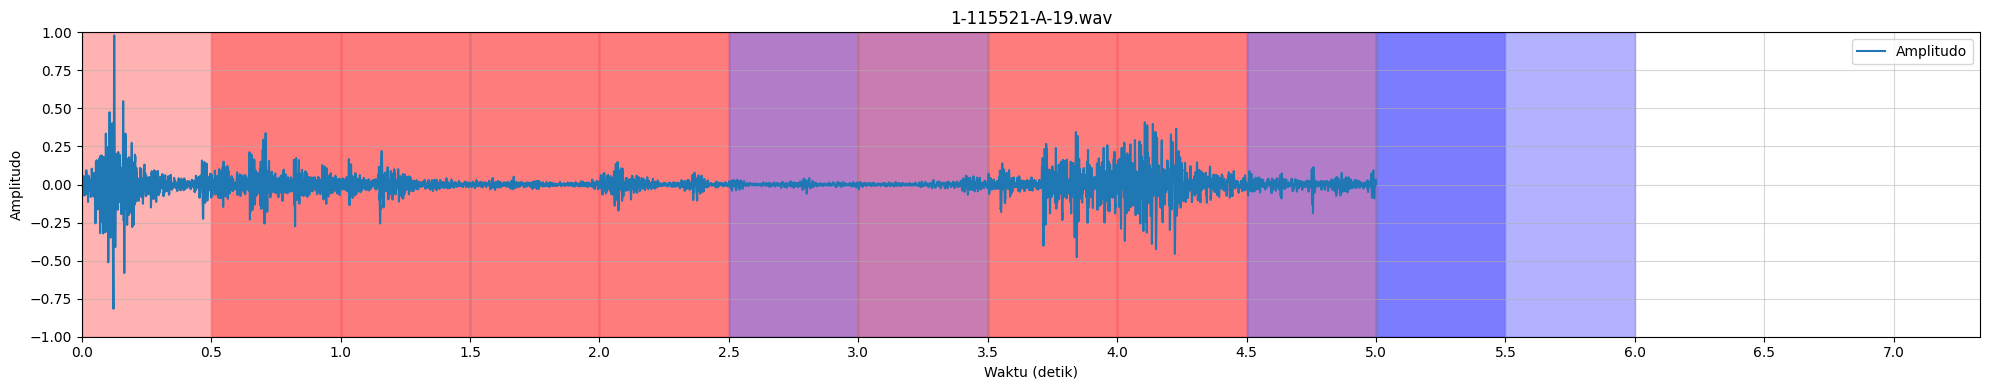

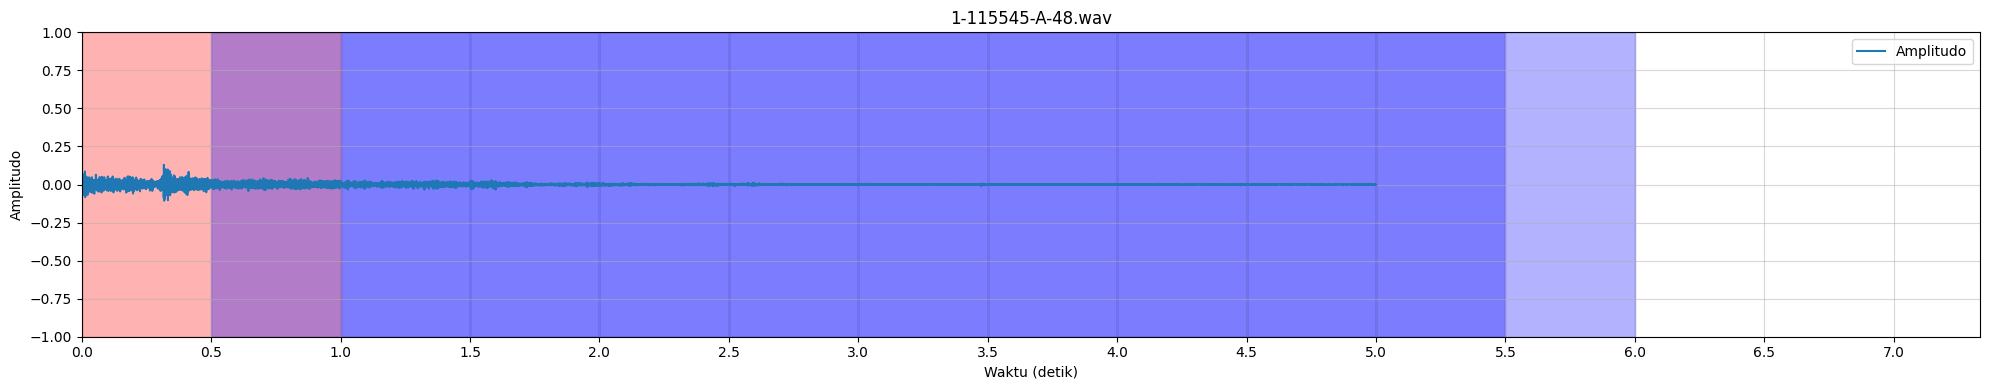

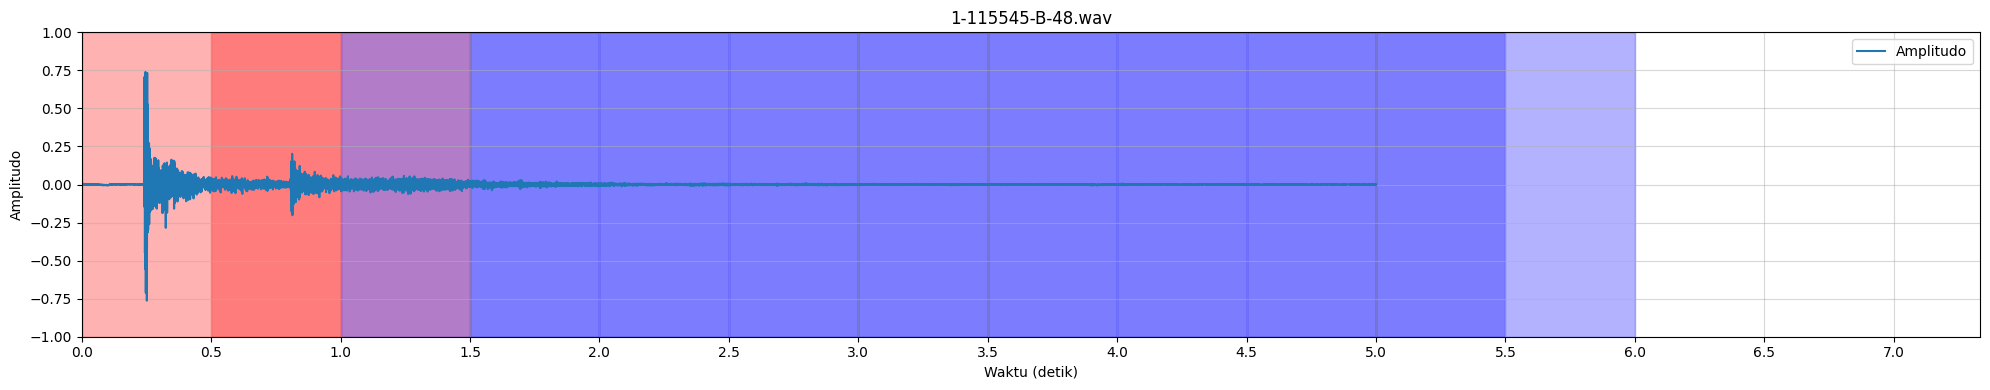

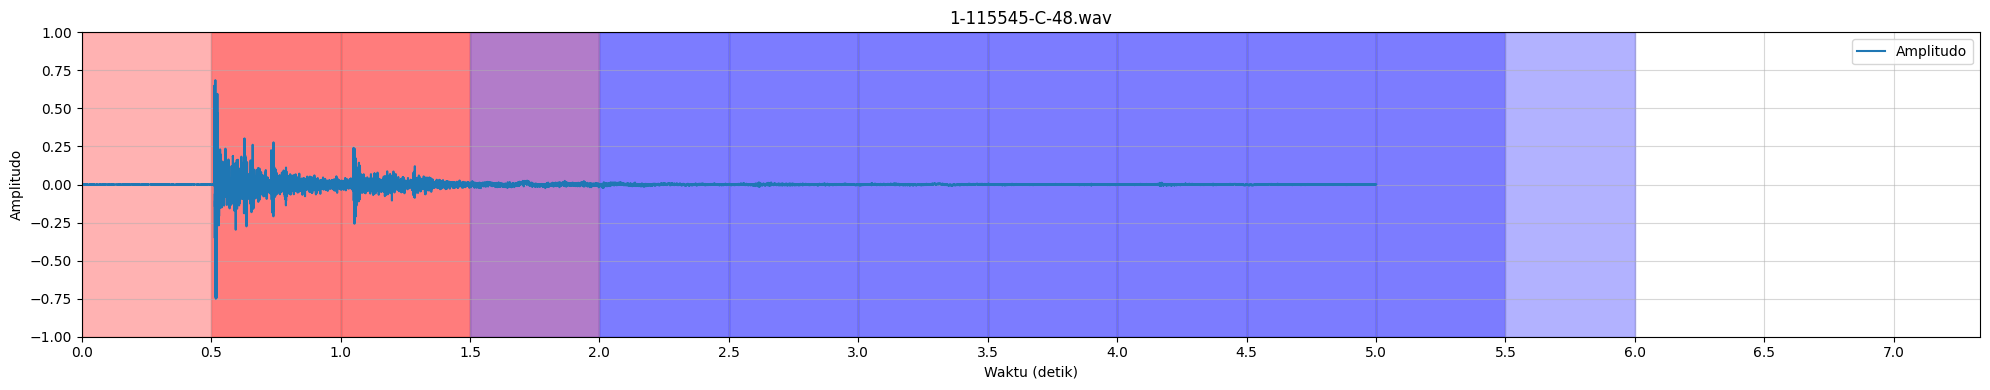

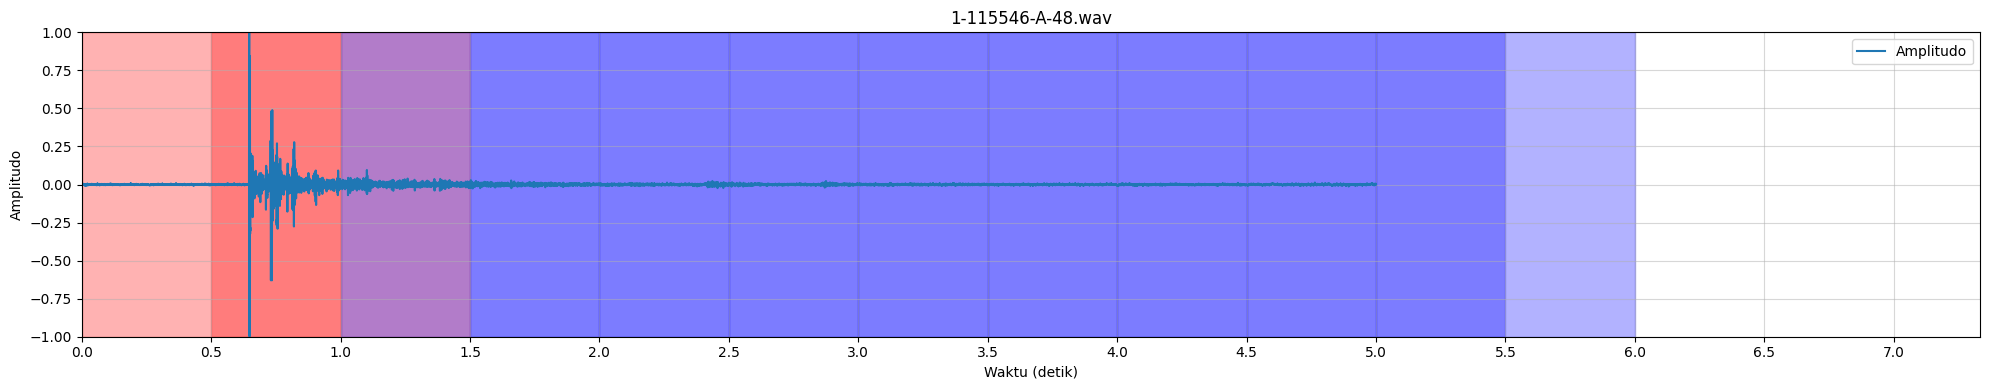

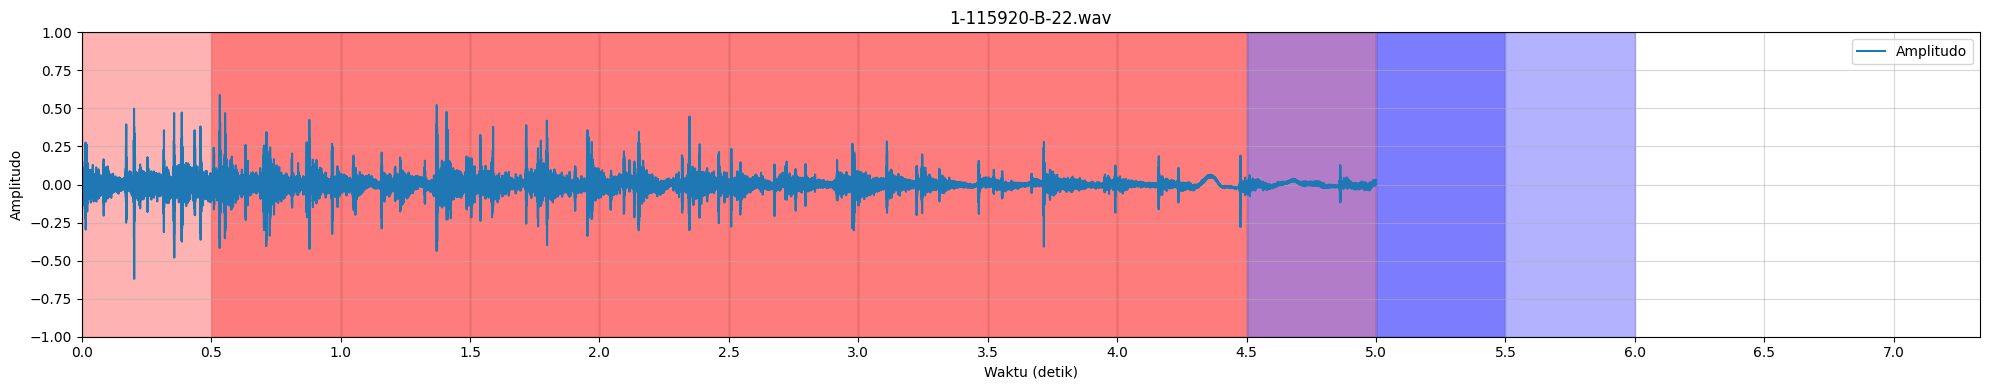

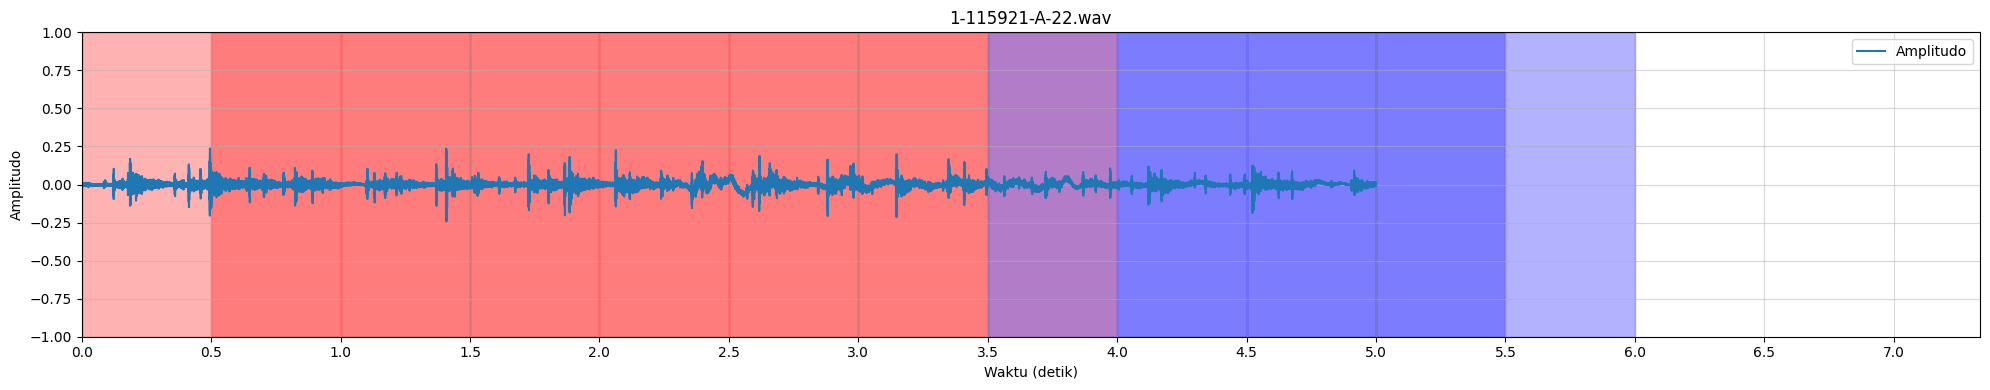

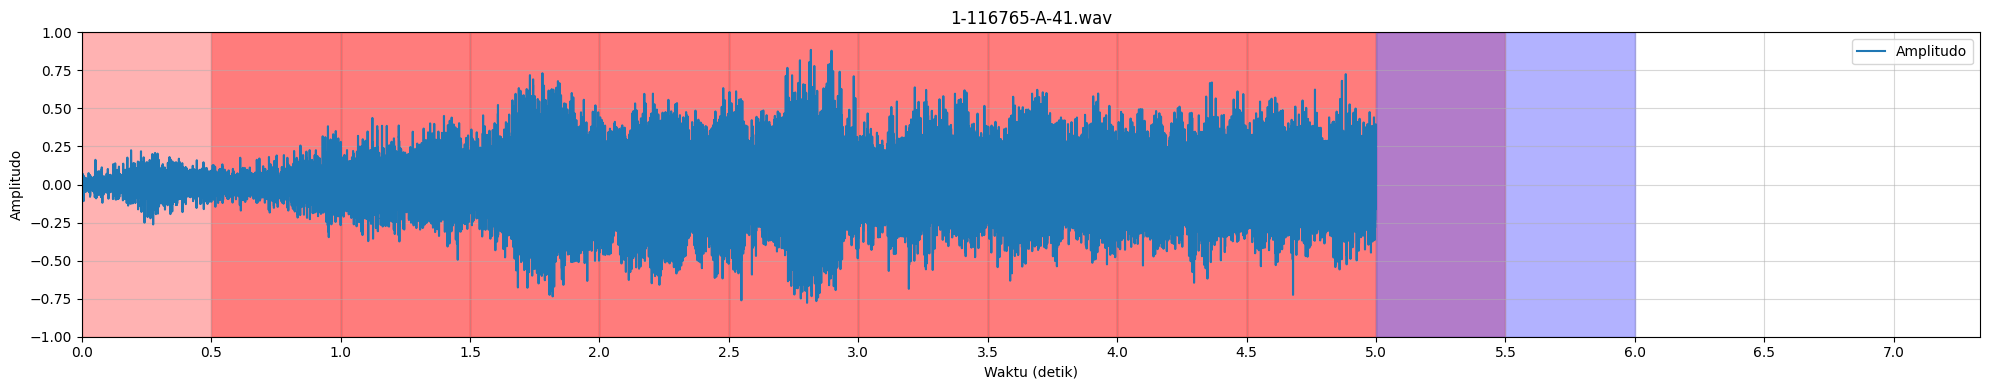

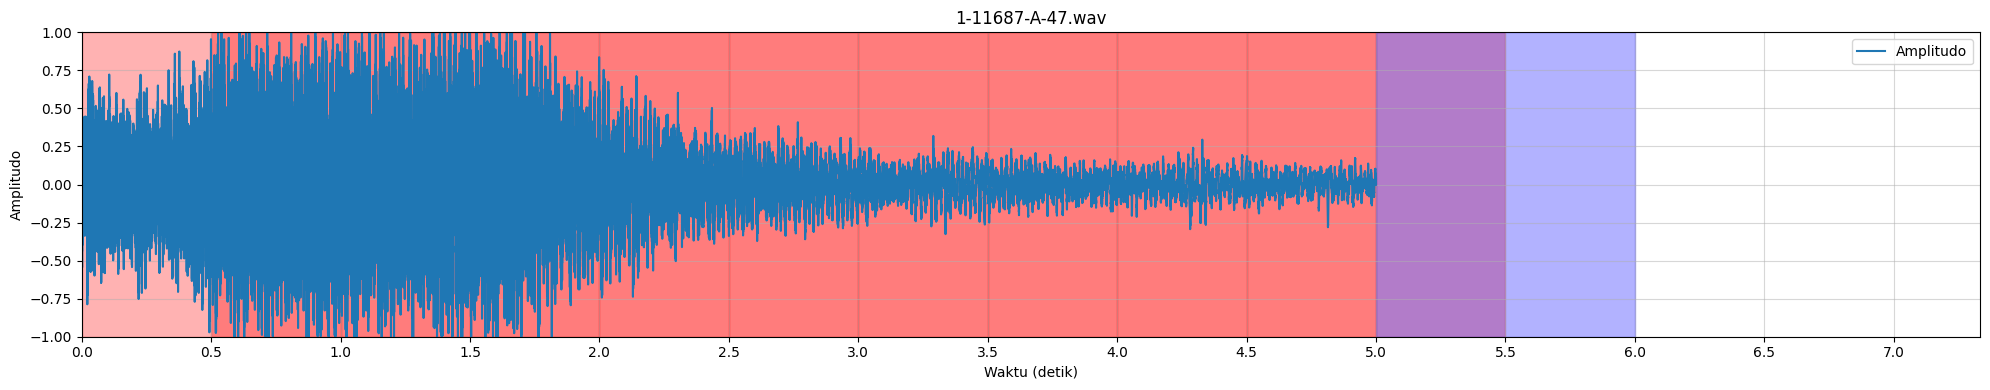

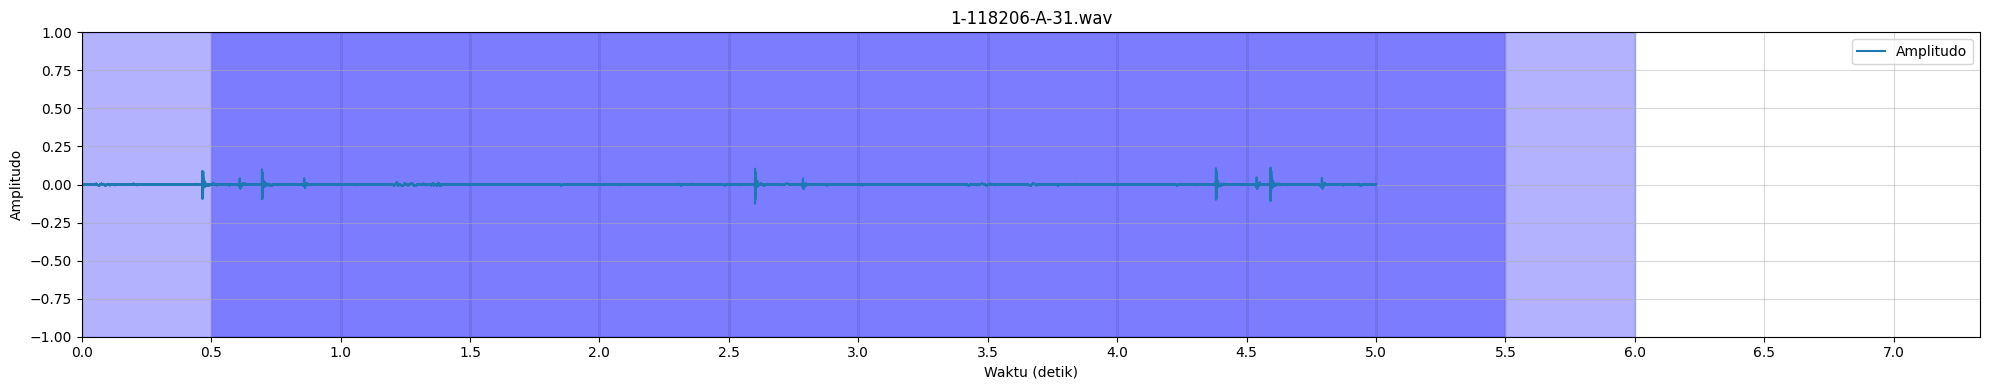

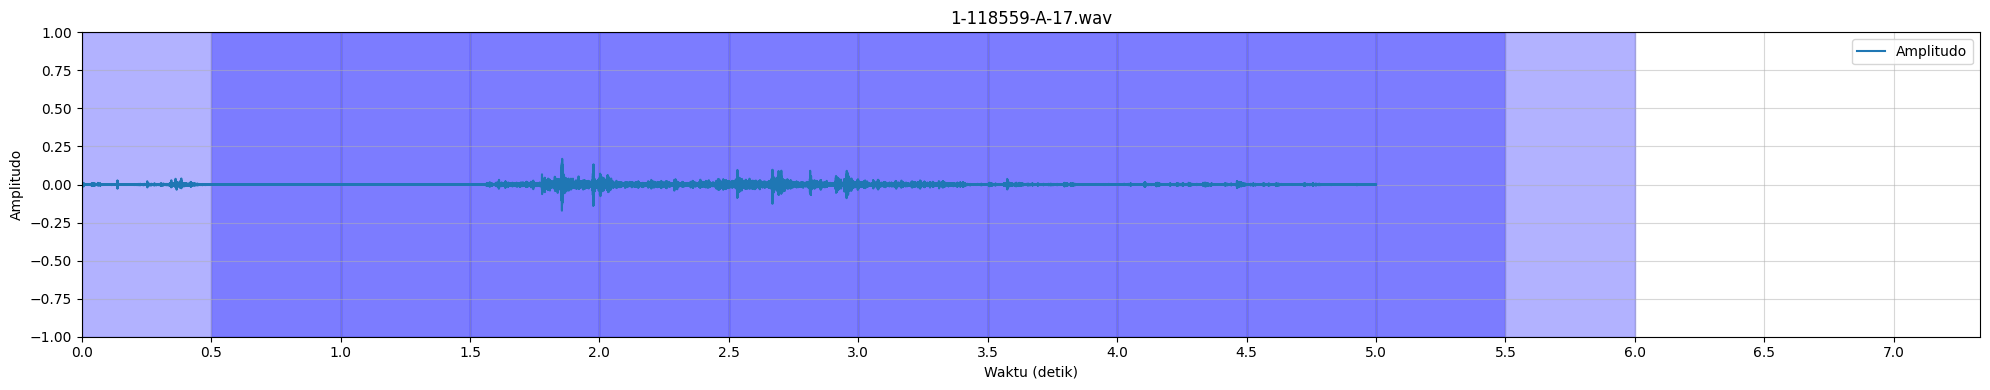

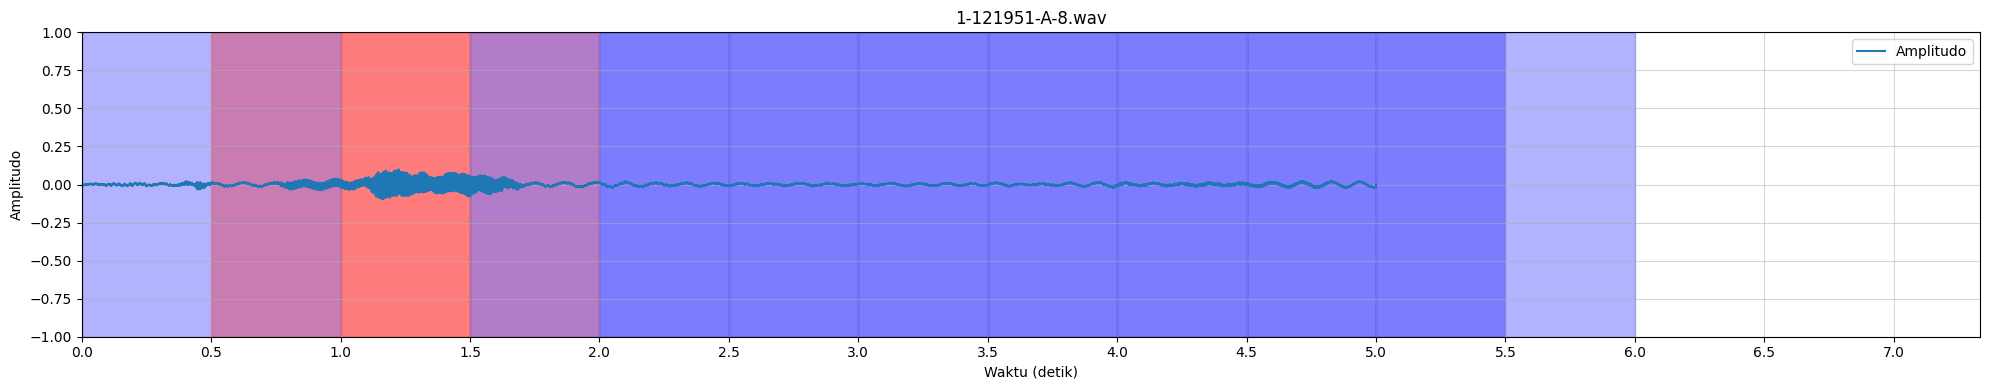

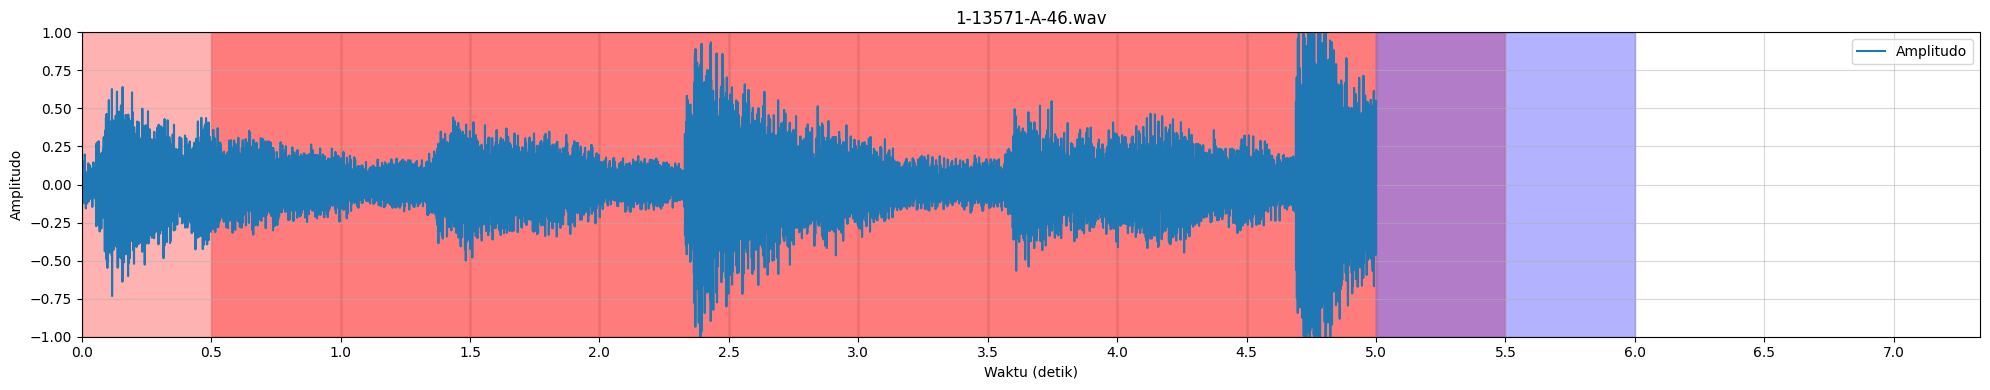

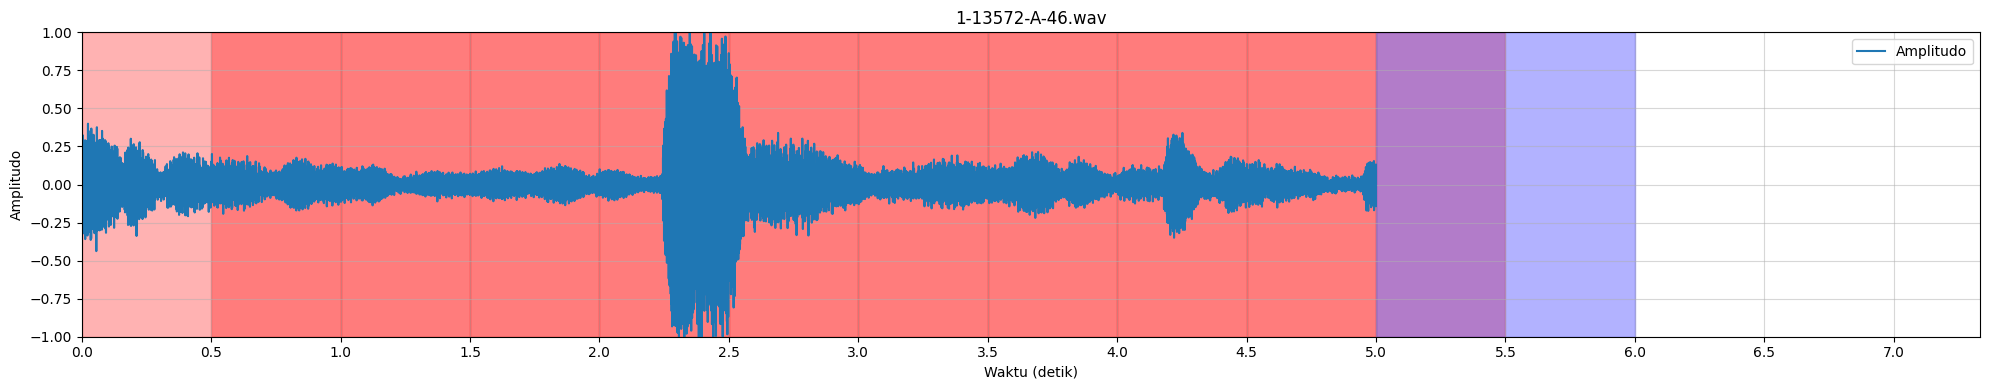

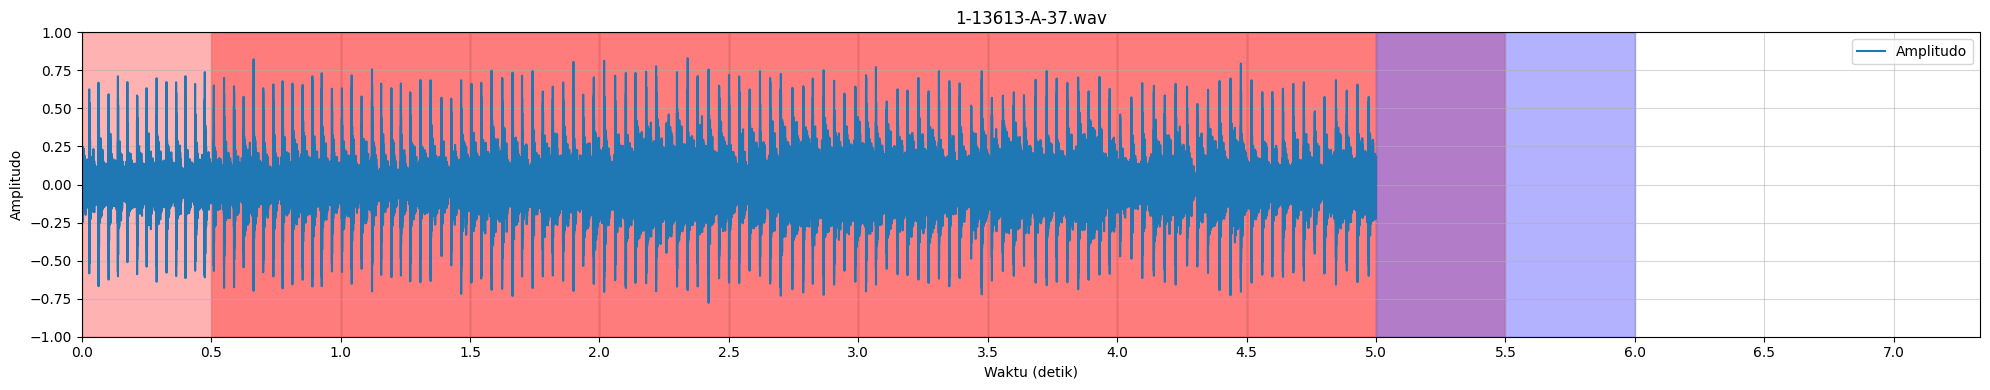

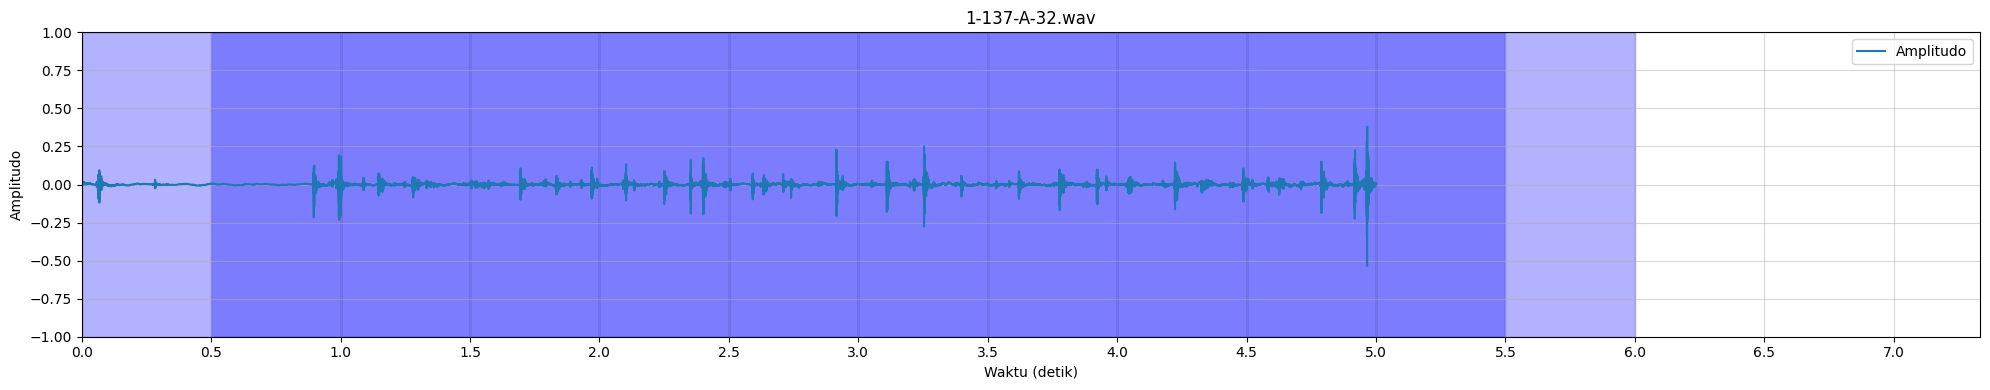

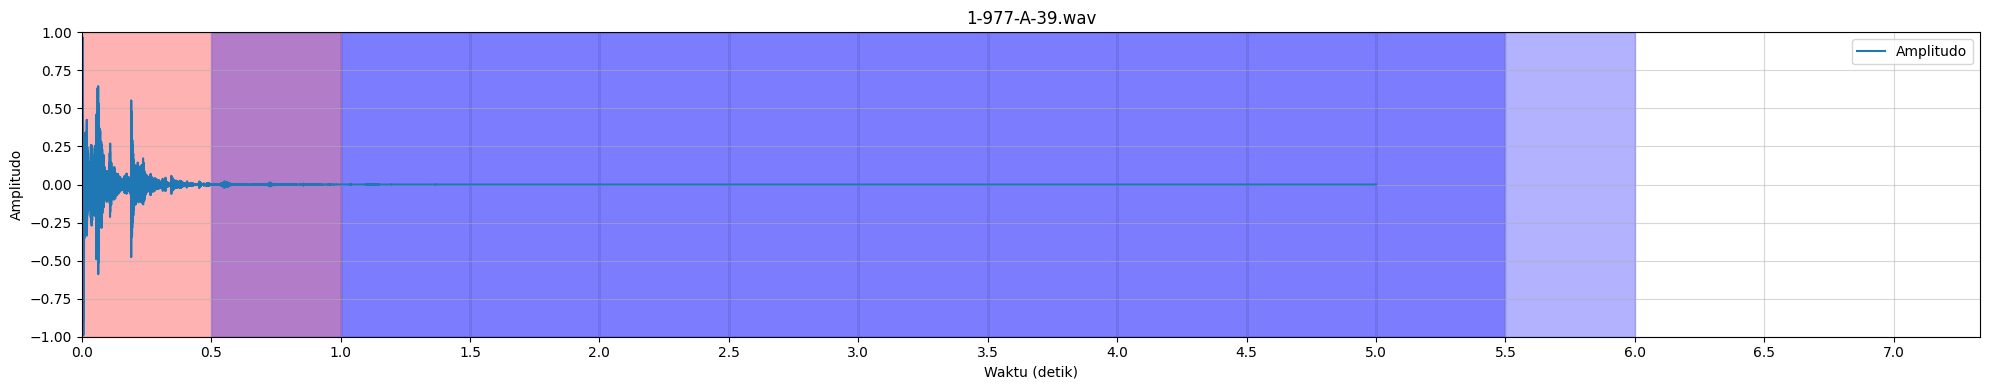

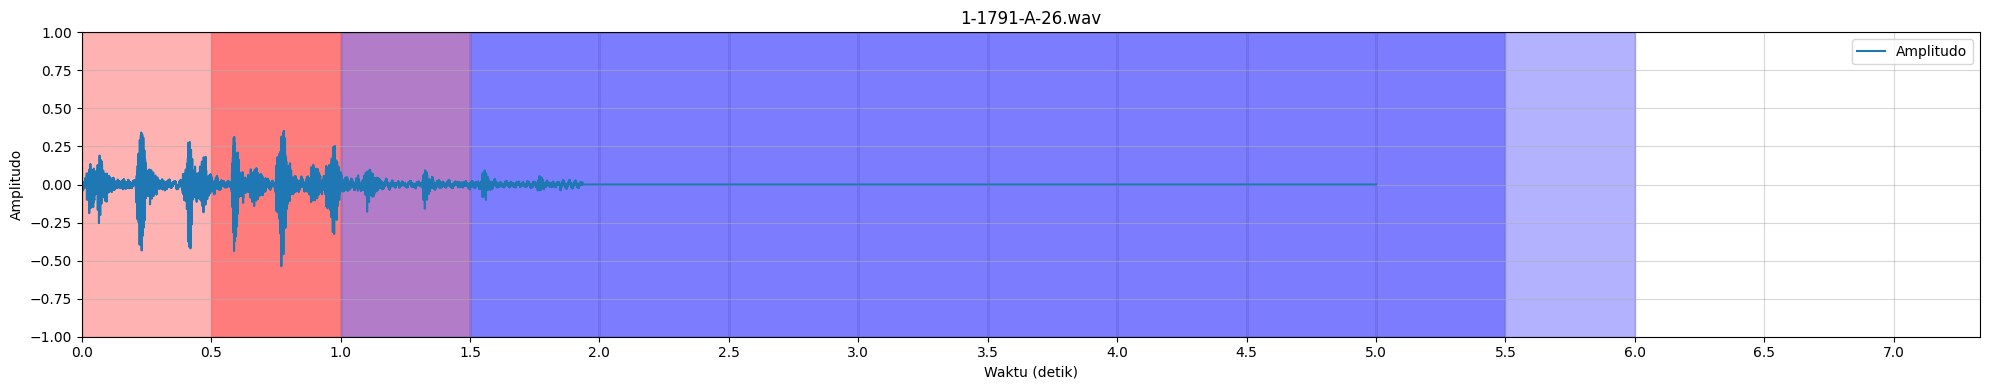

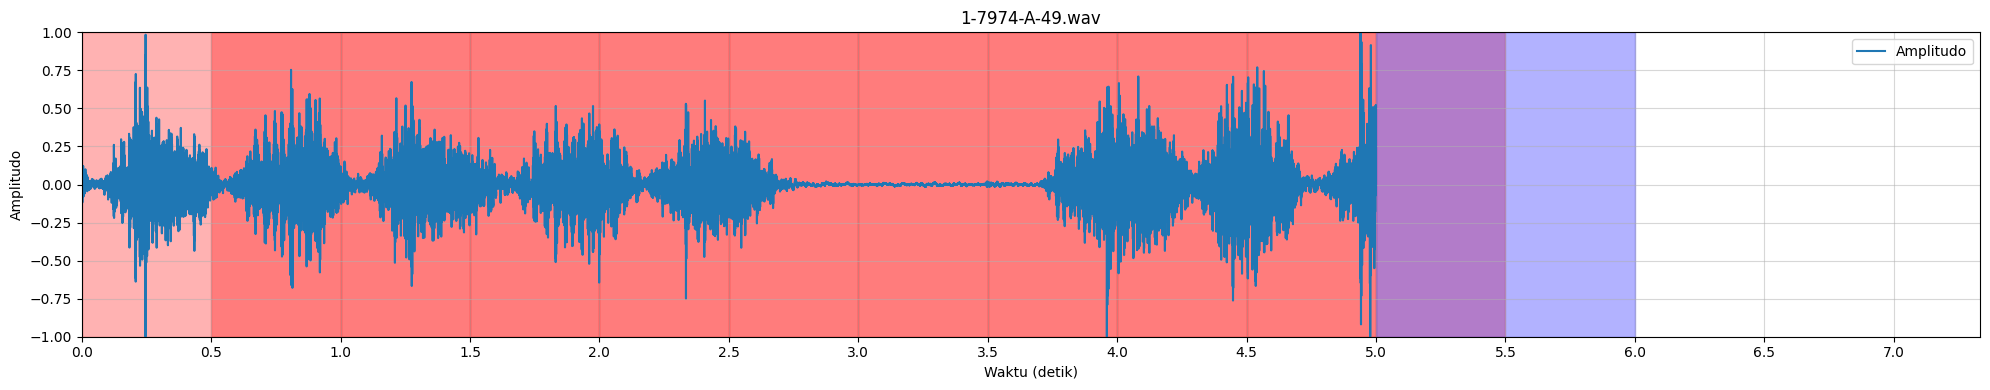

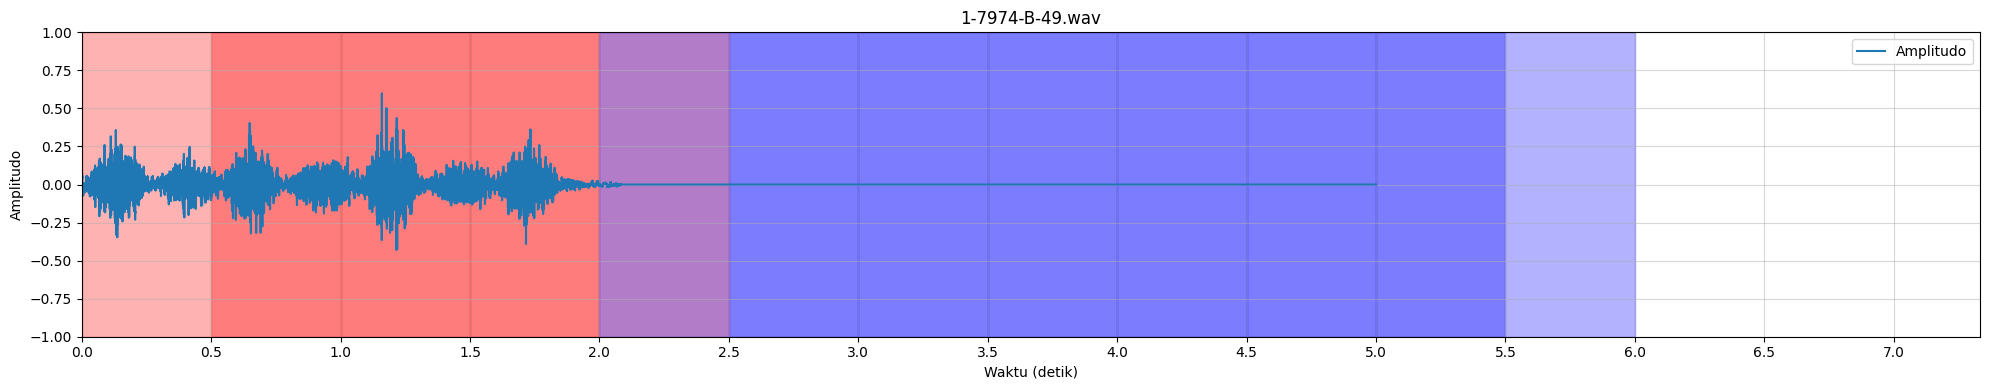

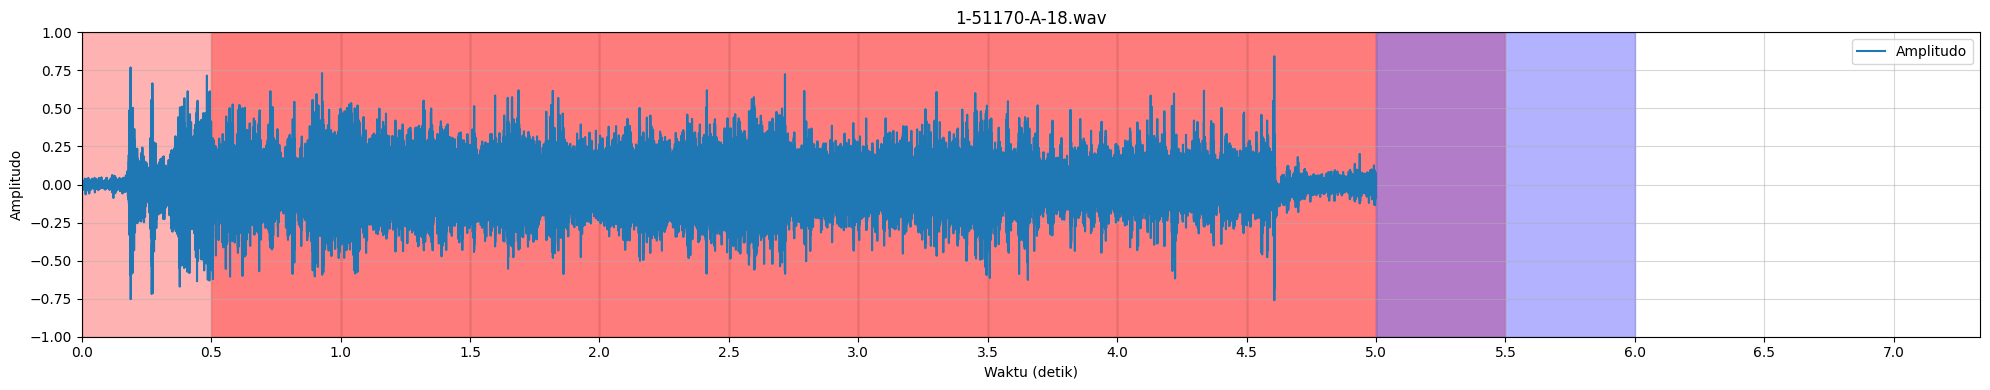

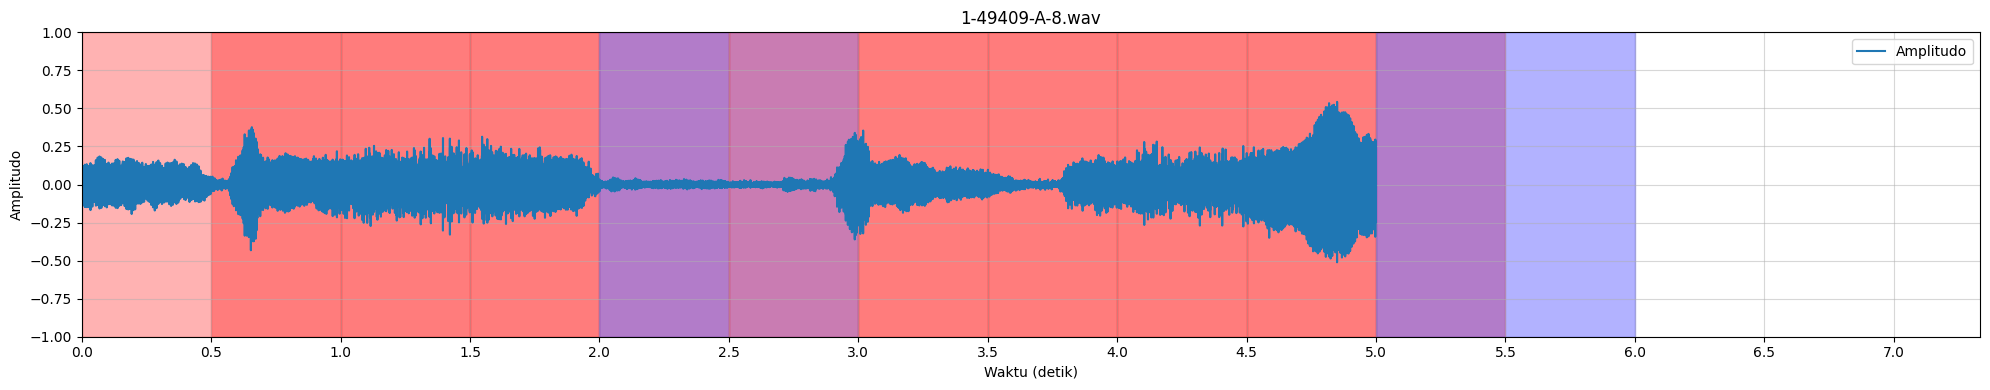

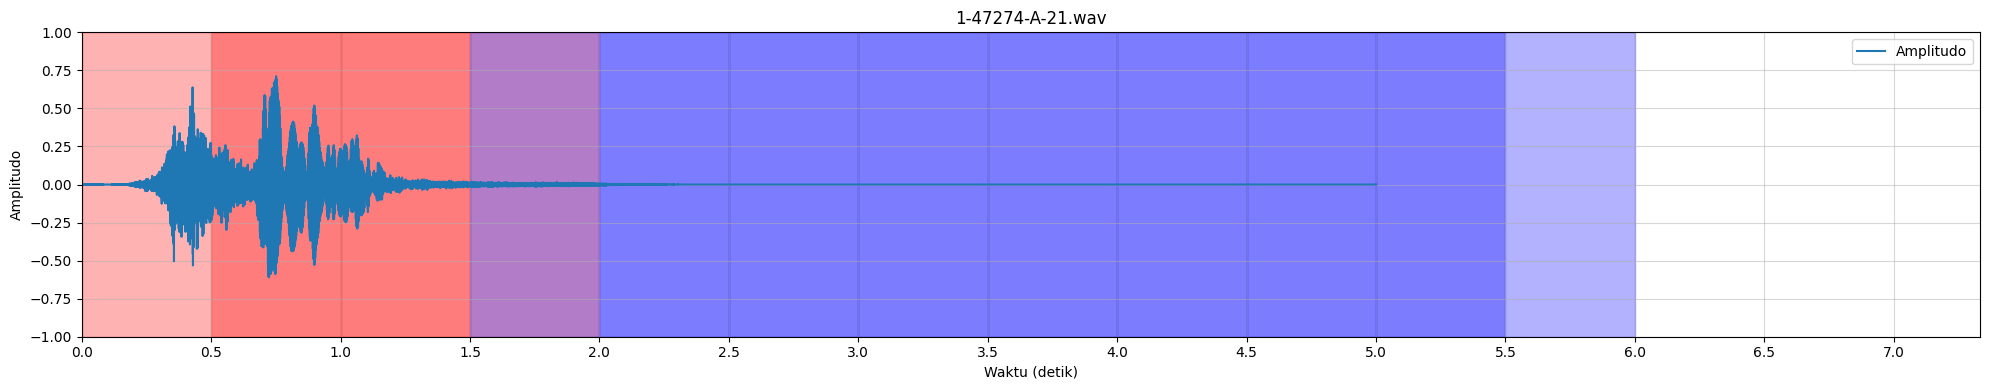

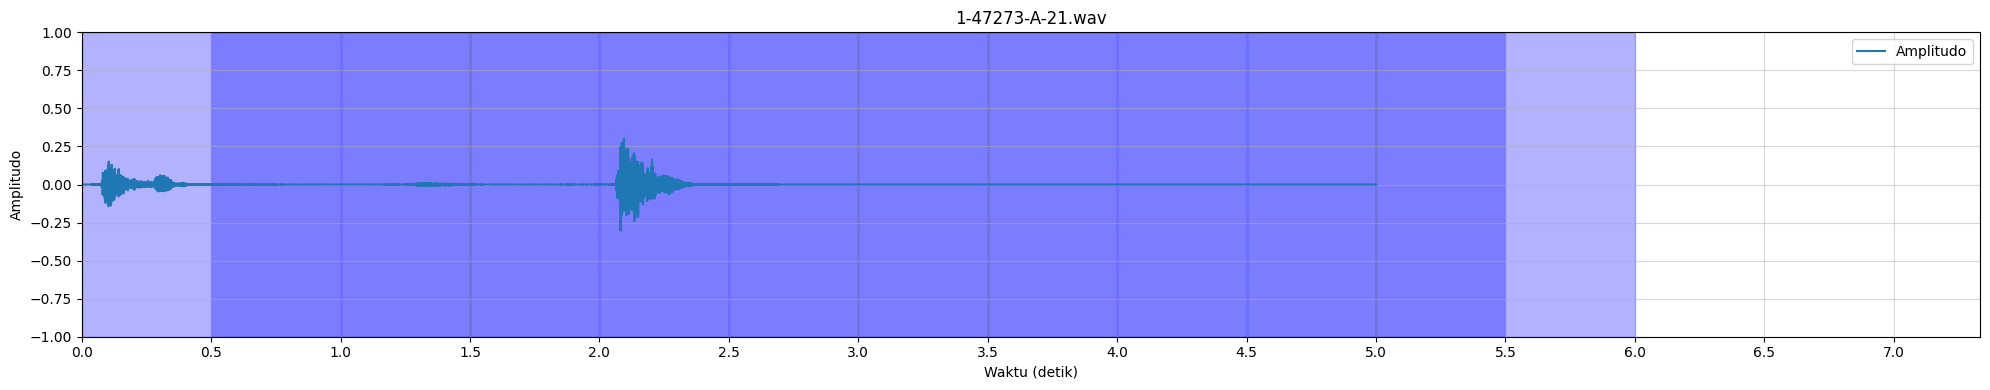

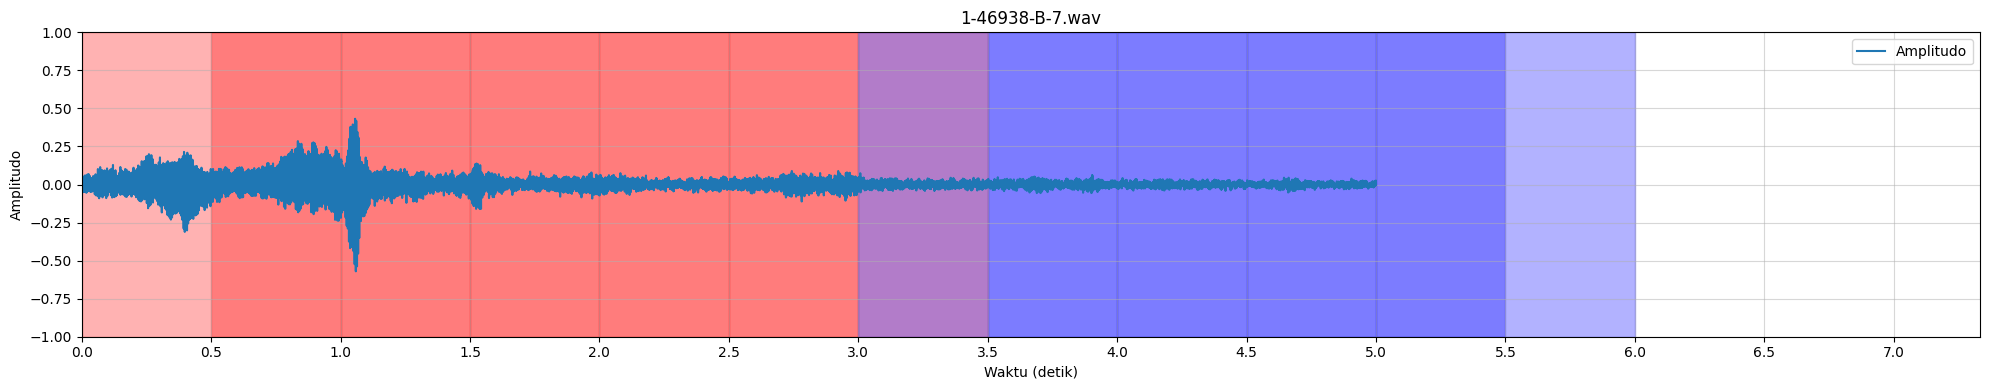

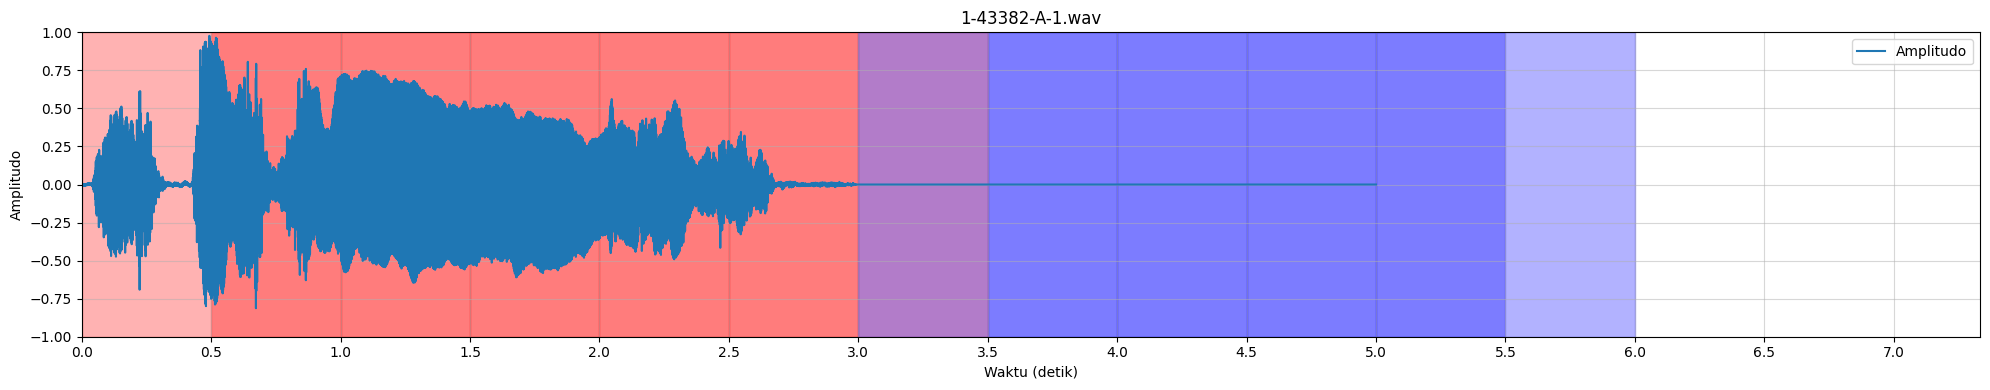

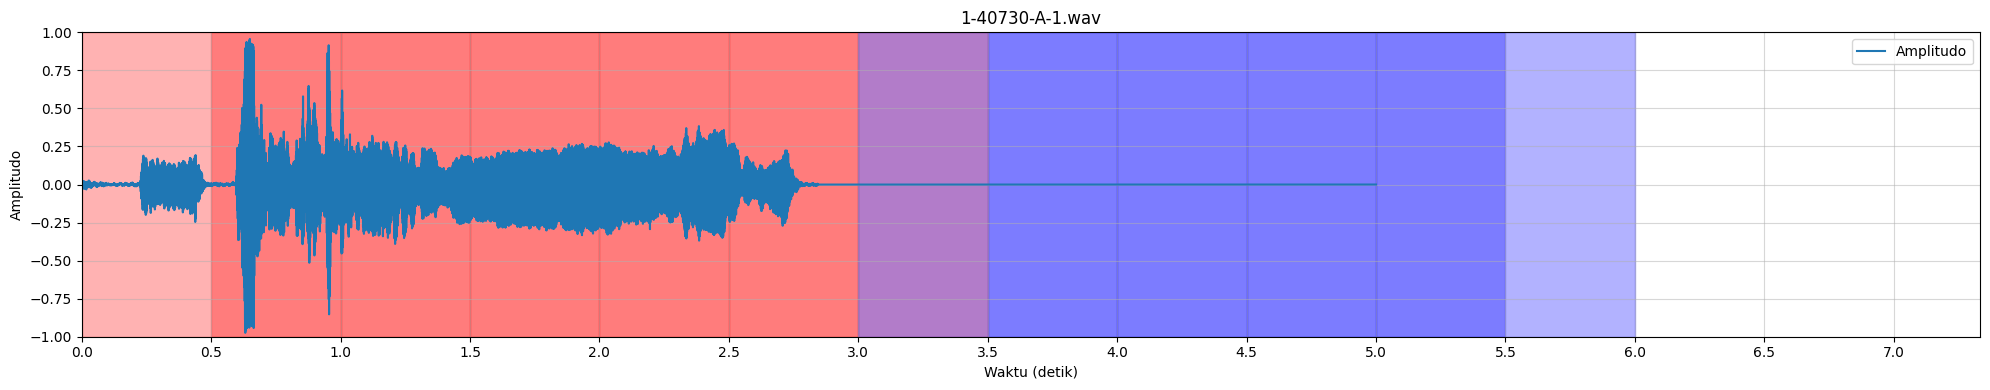

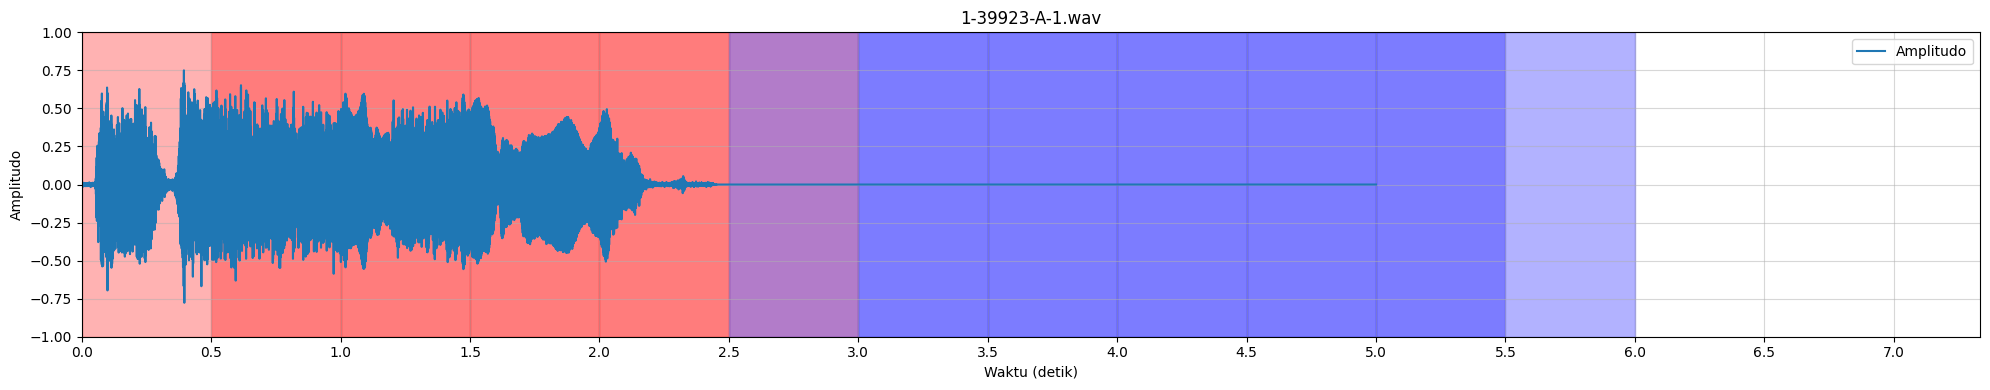

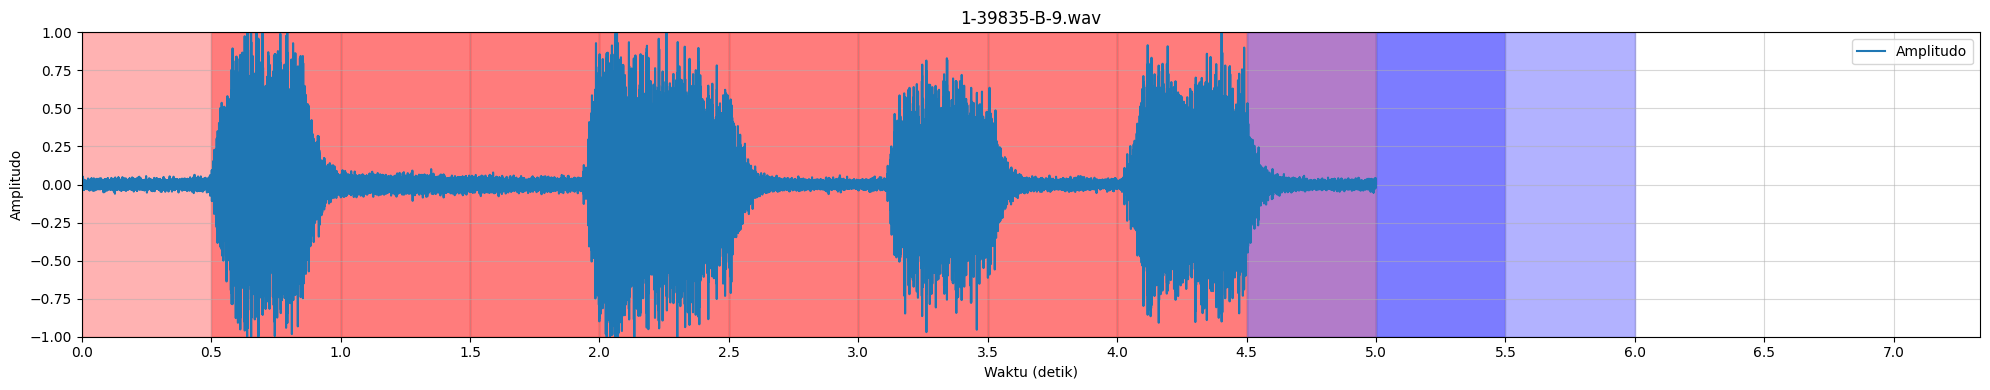

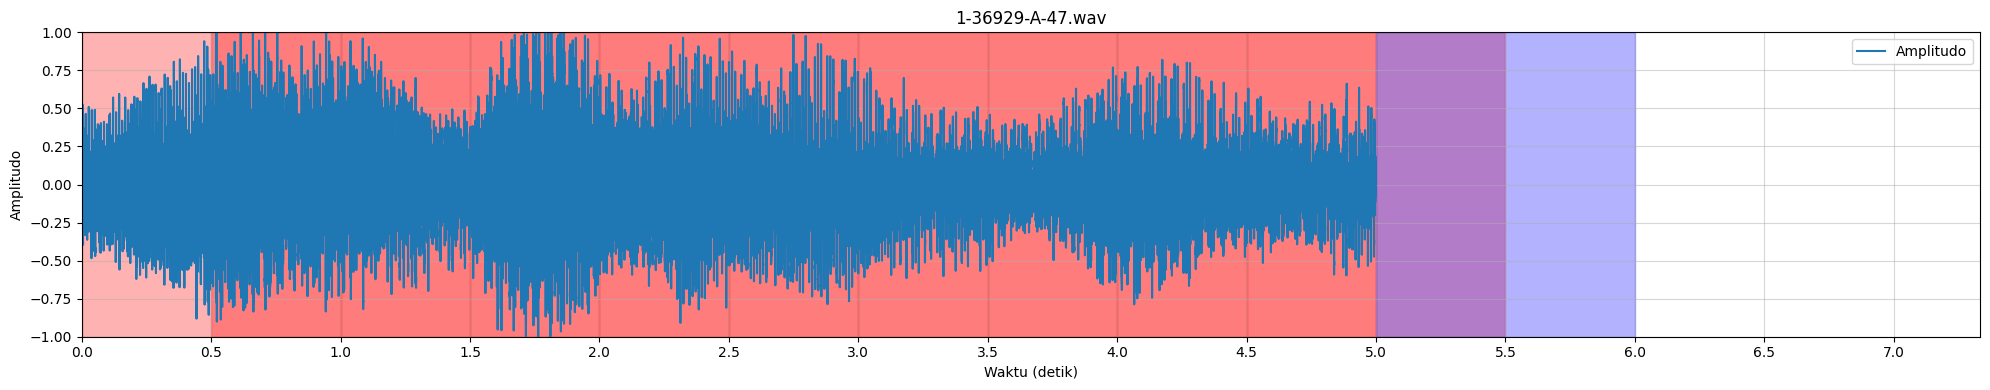

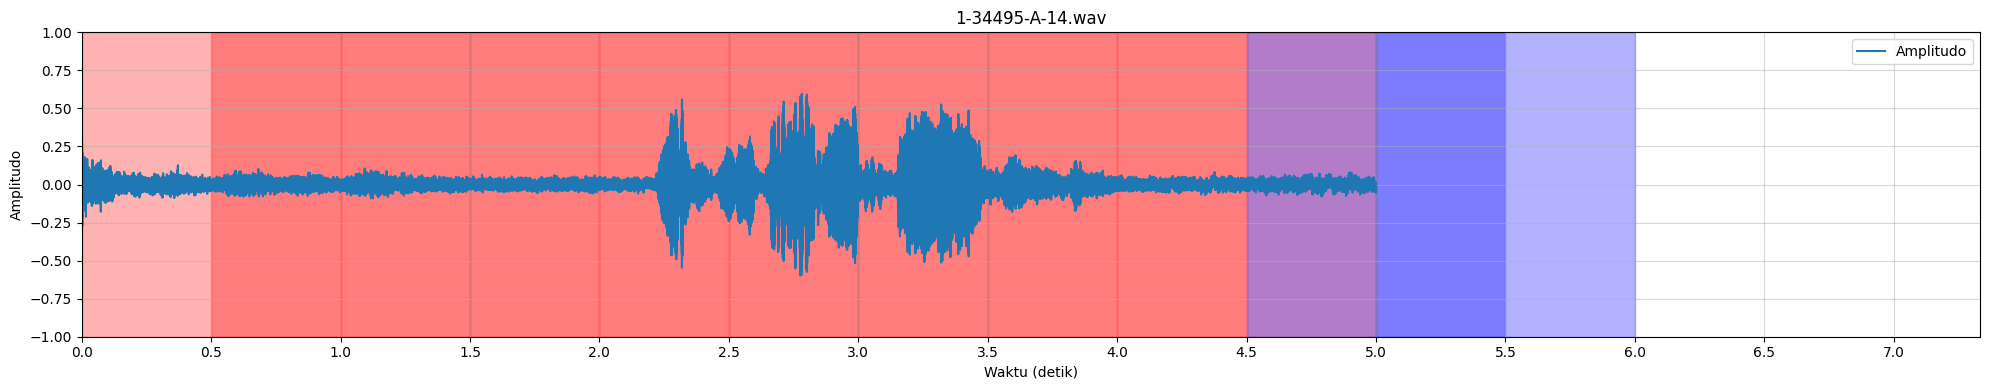

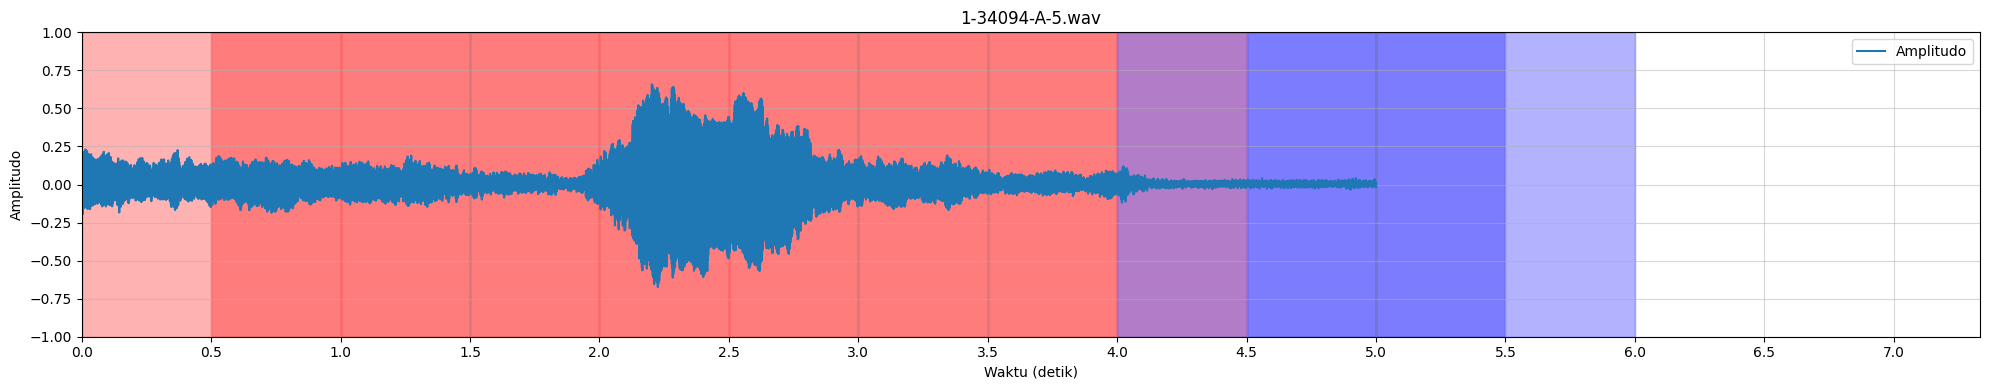

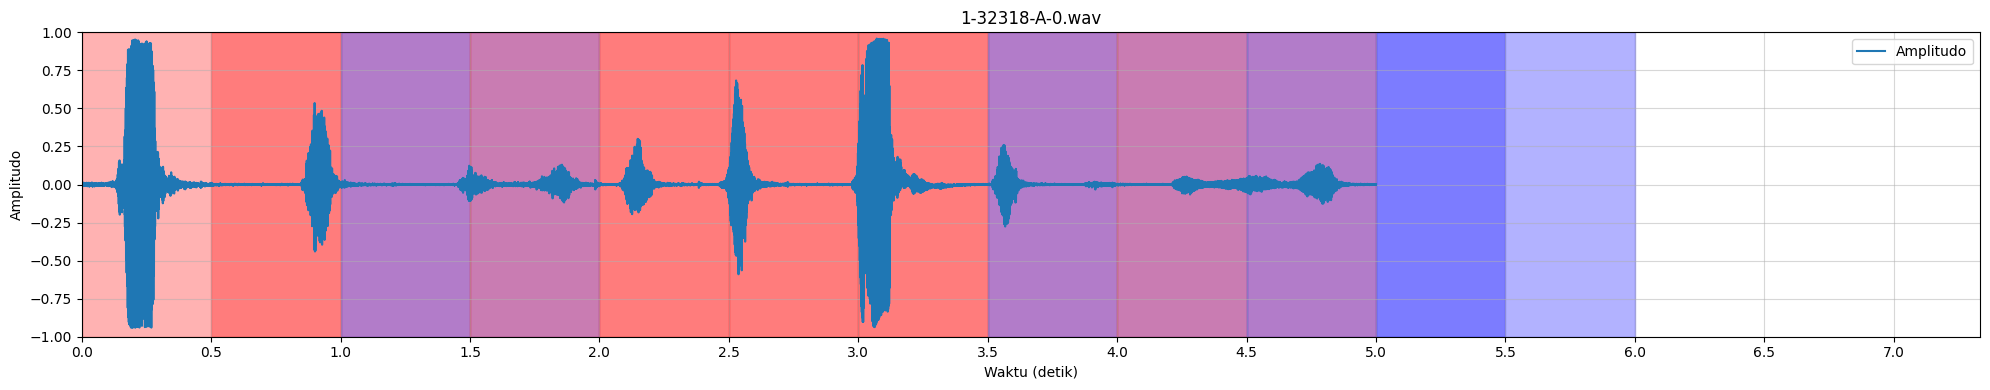

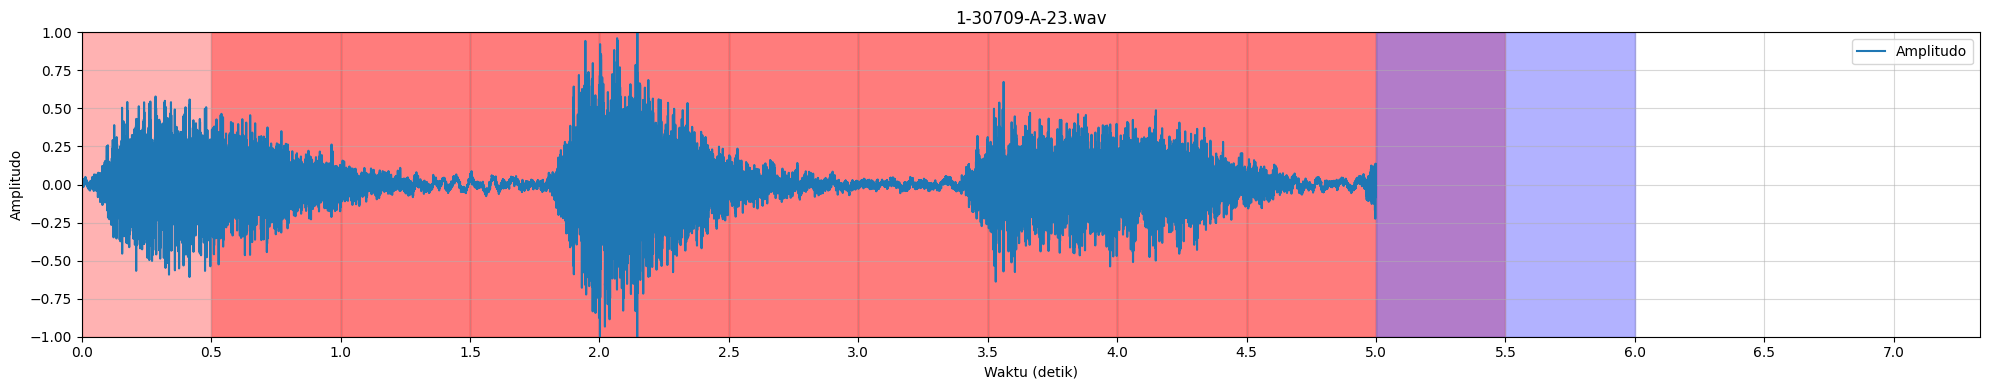

In [27]:
for i in range(0, len(dataset_raw_conc)):
    data_test = dataset_raw_conc[i]
    load_and_plot(data_test["path"], data_test["timestamp"], data_test["label"], 1/1.5 * float(len(data_test["timestamp"])))

# Pra-Pemrosesan


Function


In [28]:
def load_file_audio(path: str) -> Tuple[np.ndarray, int]:
    audio, sr = librosa.load(path, sr=SAMPLE_RATE, mono=False)
    return audio, sr

def prapemrosesan_downmixing(audio: np.ndarray) -> np.ndarray:
    if audio.ndim > 1:
        audio = np.mean(audio, axis=0)
    return audio.astype(np.float32)

def prapemrosesan_resampling(audio: np.ndarray, sr: int) -> Tuple[np.ndarray, int]:
    if sr == SAMPLE_RATE:
        return audio.copy(), SAMPLE_RATE
    audio_resampled = librosa.resample(audio, orig_sr=sr, target_sr=SAMPLE_RATE)
    return audio_resampled, SAMPLE_RATE

def prapemrosesan_padding(audio: np.ndarray) -> np.ndarray:
    if len(audio) % SEGMENT_DURATION != 0:
        padding = SEGMENT_DURATION - (len(audio) % SEGMENT_DURATION)
        audio = np.pad(audio, (0, padding), mode='constant')
    return audio

def prapemrosesan_splitting(audio: np.ndarray) -> np.ndarray:
    num_segments = int(np.floor((len(audio) - SEGMENT_DURATION) / OVERLAP_DURATION)) + 1
    segments = np.lib.stride_tricks.as_strided(
        audio,
        shape=(num_segments, SEGMENT_DURATION),
        strides=(OVERLAP_DURATION * audio.strides[0], audio.strides[0]),
        writeable=False
    )
    if len(segments[-1]) < SEGMENT_DURATION:
        segments[-1] = np.pad(segments[-1], (0, SEGMENT_DURATION - len(segments[-1])), 'constant')
    return segments

Function Utama


In [29]:
def prapemrosesan(path : str) -> np.ndarray:
    audio, sr = load_file_audio(path)
    audio = prapemrosesan_downmixing(audio)
    audio, sr = prapemrosesan_resampling(audio, sr)
    audio = prapemrosesan_padding(audio)
    segments = prapemrosesan_splitting(audio)

    return segments

# Ekstraksi Fitur


Function


In [30]:
def get_rms(segment):
    return np.mean(librosa.feature.rms(y=segment))

def get_spectral_flatness(segment):
    return np.mean(librosa.feature.spectral_flatness(y=segment))

def get_mfcc(segment):
    return librosa.feature.mfcc(y=segment, sr=SAMPLE_RATE)

def get_mfcc_mean(segment):
    mfcc = librosa.feature.mfcc(y=segment, sr=SAMPLE_RATE)
    return np.mean(mfcc)

def get_mfcc_std(segment):
    mfcc = librosa.feature.mfcc(y=segment, sr=SAMPLE_RATE)
    return np.std(mfcc)

Generete fitur tiap segment


In [ ]:
dataset_fe = []

for data in dataset_raw:
    segments = prapemrosesan(data["path"])
    index = int(data["timestamp"][0] / 0.5)
    segment = segments[index]

    data = {
        "path": data["path"],
        "name": data["name"],
        "timestamp": data["timestamp"],
        "label": data["label"],
        "raw": segment,
        
        "rms": get_rms(segment),
        "spectral_flatness": get_spectral_flatness(segment),
        "mfcc": get_mfcc(segment),
        "mfcc_std": get_mfcc_std(segment),
        "mfcc_mean": get_mfcc_mean(segment),
    }

    dataset_fe += [data]

Save


In [ ]:
with open(f"{MAIN_PATH}/Dataset/dataset_fe.pkl", "wb") as f:
    pickle.dump(dataset_fe, f)

with open(f"{MAIN_PATH}/Dataset/dataset_raw.pkl", "wb") as f:
    pickle.dump(dataset_raw, f)

# EDA


In [ ]:
with open(f"{MAIN_PATH}/Dataset/dataset_fe.pkl", "rb") as f:
    dataset_fe = pickle.load(f)

Membuat pandas dataframe


In [ ]:
df = pd.DataFrame(dataset_fe, columns=["path", "nama", "timestamp", "label", "raw", "rms", "spectral_flatness", "mfcc", "mfcc_std", "mfcc_mean"])

In [ ]:
df_p = df.copy()
df_p["label"] = df_p["label"].apply(lambda x: 1 if x in [0, 1] else x)

df_k = df.copy()
df_k["label"] = df_k["label"].apply(lambda x: 1 if x in [1, 2] else x)

Describe data numerik


In [ ]:
df.describe()[["rms", "spectral_flatness", "mfcc_std", "mfcc_mean"]]

rms  spectral_flatness     mfcc_std    mfcc_mean
count  1894.000000        1894.000000  1894.000000  1894.000000
mean      0.041683           0.091586   102.355209   -20.278717
std       0.058063           0.265387    47.339115    13.818110
min       0.000000           0.000003    34.111572   -56.568550
25%       0.008246           0.000198    74.236889   -24.864371
50%       0.022028           0.000651    89.945862   -17.789854
75%       0.051444           0.001648   115.127127   -11.364056
max       0.445492           1.000001   246.576553     8.562992

Korelasi


In [ ]:
feature_cols = ["rms", "spectral_flatness", "mfcc_std", "mfcc_mean"]

In [ ]:
df_features = df_p[feature_cols + ['label']]

if df_features['label'].dtype == 'object' or df_features['label'].dtype.name == 'category':
    df_features['label'] = df_features['label'].astype('category').cat.codes

correlation = df_features.corr()

print(correlation['label'].drop('label'))

rms                 -0.406285
spectral_flatness    0.462442
mfcc_std             0.621816
mfcc_mean           -0.567348
Name: label, dtype: float64


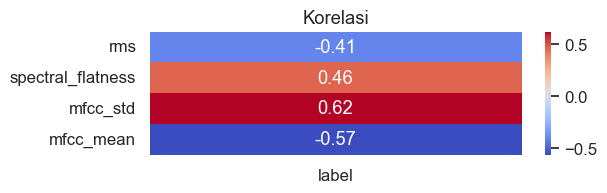

In [ ]:
correlation = df_p[feature_cols + ['label']].corr()
label_corr = correlation['label'].drop('label')

plt.figure(figsize=(6, len(label_corr) * 0.4))
sns.heatmap(
    label_corr.to_frame(),
    annot=True,
    cmap='coolwarm'
)
plt.title('Korelasi')
plt.show()

Scatter plot rms x flatness


In [ ]:
df_0 = df[df["label"] == 0]
df_1 = df[df["label"] == 1]
df_2 = df[df["label"] == 2]
df_01 = df[(df["label"] == 0) | (df["label"] == 1)]
df_12 = df[(df["label"] == 1) | (df["label"] == 2)]
df_02 = df[(df["label"] == 0) | (df["label"] == 2)]

In [37]:
with open(f"{MAIN_PATH}/Dataset/dataset_fe.pkl", "rb") as f:
    dataset_fe = pickle.load(f)

df_scaled = pd.DataFrame(dataset_fe, columns=["rms", "spectral_flatness", "label"])

In [38]:
k_scl = joblib.load(MAIN_PATH + "/Model/p_scaler.pkl")

features = df_scaled[["rms", "spectral_flatness"]]
label = df_scaled["label"]

features_scaled = pd.DataFrame(k_scl.transform(features), columns=["rms", "spectral_flatness"])

df_scaled = pd.concat([features_scaled, label.reset_index(drop=True)], axis=1)

C:\Users\Lulay\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


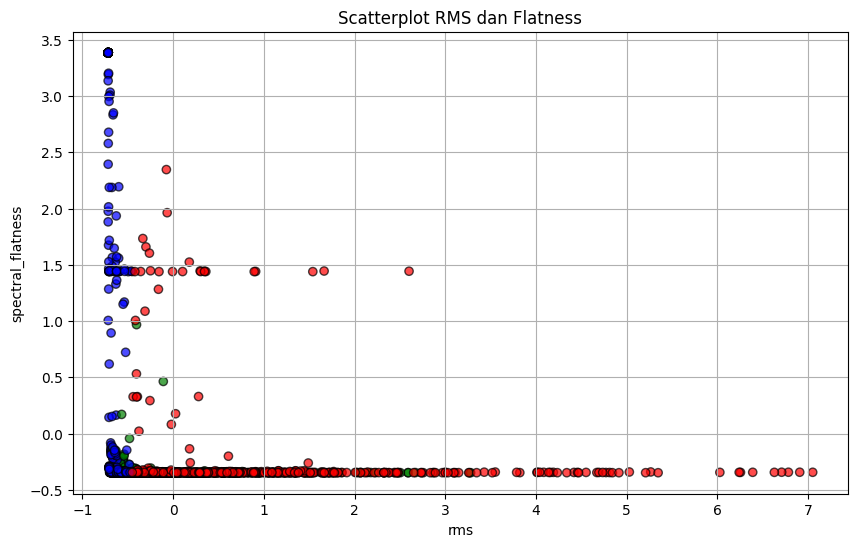

In [39]:
colors = df_scaled['label'].map({2: 'blue', 1: 'red', 0:'green'})

plt.figure(figsize=(10, 6))
plt.scatter(df_scaled['rms'], df_scaled['spectral_flatness'], c=colors, alpha=0.7, edgecolors='k')
plt.ylabel('spectral_flatness')
plt.xlabel('rms')

plt.grid(True, which='both')
plt.title("Scatterplot RMS dan Flatness")
plt.show()